# Import & Plot

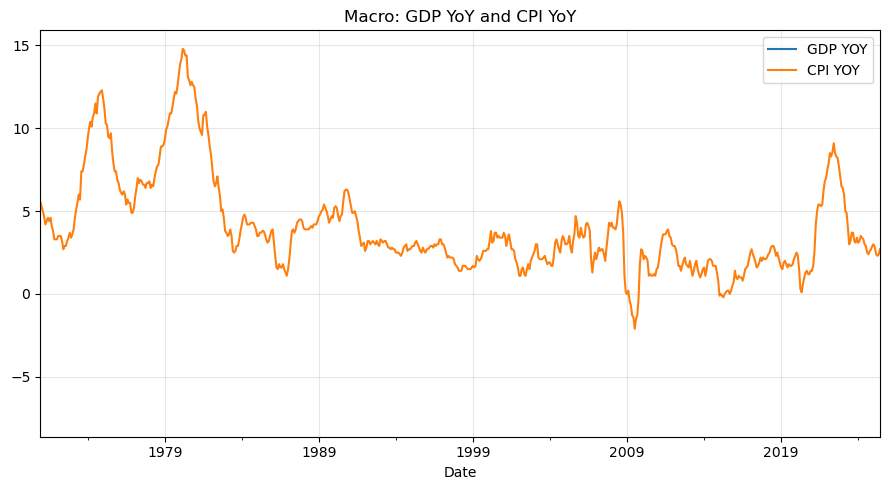

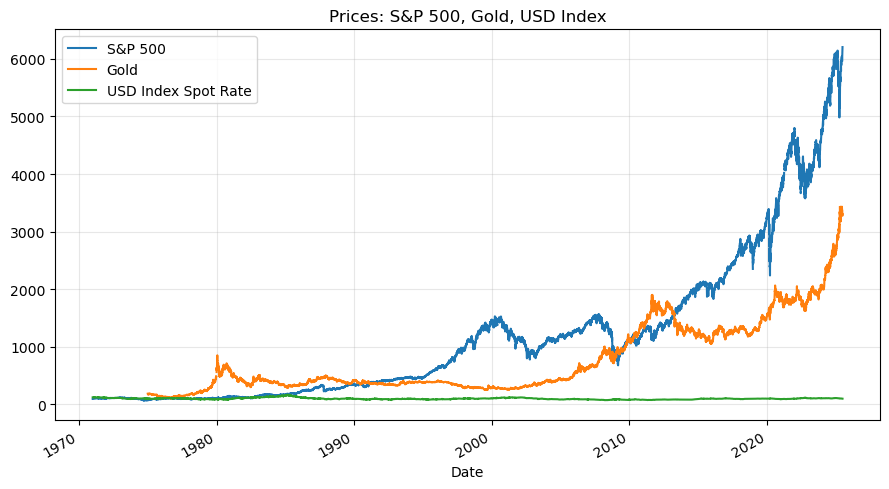

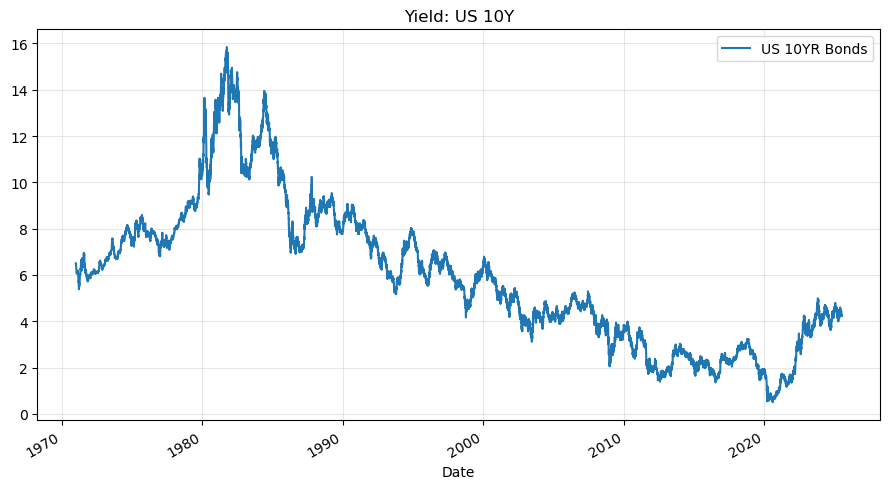

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

xlsx_path = "Data_310725.xlsx" 

# Load
dfs = pd.read_excel(xlsx_path, sheet_name=["Macro", "Prices", "Yield"])

def plot_sheet(df, title):
    df = df.copy()
    # Finding a date column
    date_col = next((c for c in df.columns if c.lower().startswith("date")), df.columns[0])
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col)

    value_cols = [c for c in df.columns if c != date_col]
    ax = df.plot(x=date_col, y=value_cols, figsize=(9, 5))
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot
plot_sheet(dfs["Macro"],  "Macro: GDP YoY and CPI YoY")
plot_sheet(dfs["Prices"], "Prices: S&P 500, Gold, USD Index")
plot_sheet(dfs["Yield"],  "Yield: US 10Y")

# Overlays 

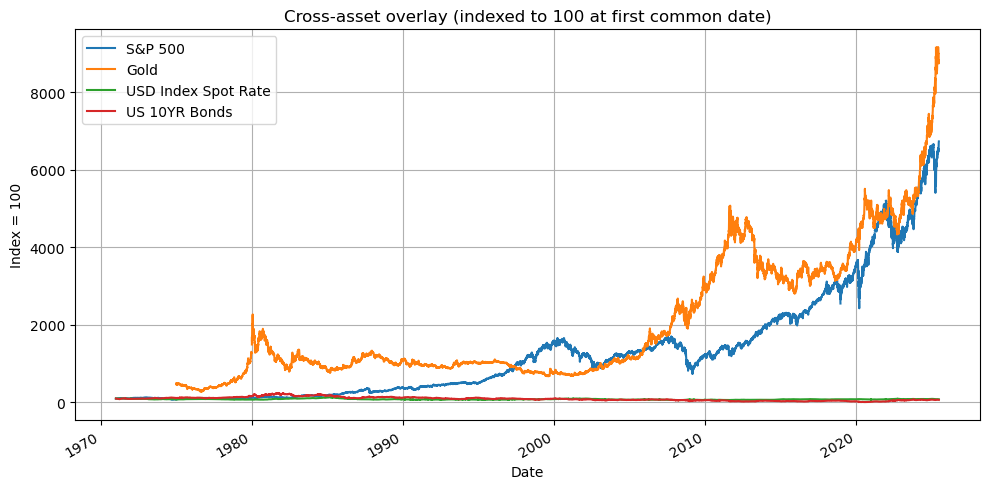

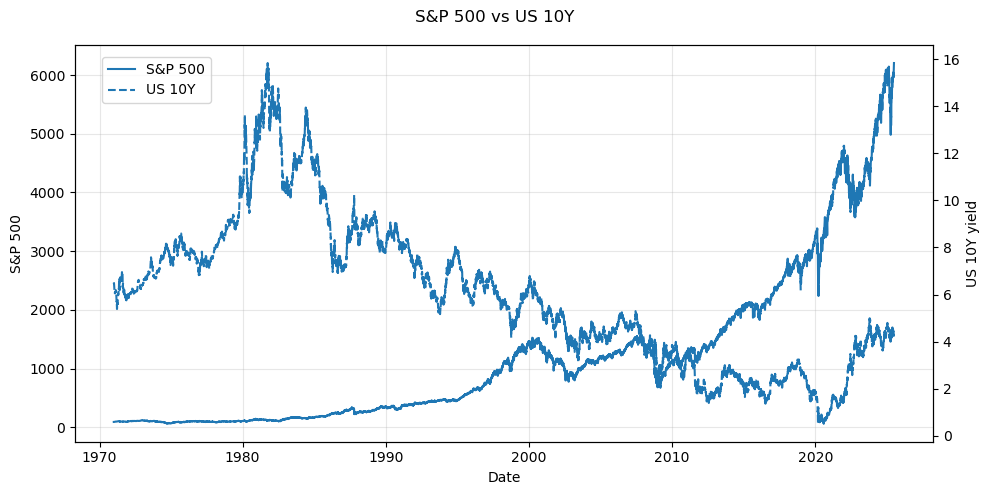

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

for k in dfs:
    date_col = next((c for c in dfs[k].columns if c.lower().startswith("date")), dfs[k].columns[0])
    dfs[k] = dfs[k].rename(columns={date_col: "Date"})
    dfs[k]["Date"] = pd.to_datetime(dfs[k]["Date"], errors="coerce")
    dfs[k] = dfs[k].dropna(subset=["Date"]).sort_values("Date")

# 1) Cross-asset overlay, indexed to 100 @ first common date
cols_prices = ["S&P 500", "Gold", "USD Index Spot Rate"]
cols_yield  = ["US 10YR Bonds"]

merged = reduce(
    lambda l, r: pd.merge(l, r, on="Date", how="inner"),
    [dfs["Prices"][["Date"] + cols_prices], dfs["Yield"][["Date"] + cols_yield]]
)

plot_cols = cols_prices + cols_yield
base_row = merged.dropna(subset=plot_cols).iloc[0]

indexed = merged[["Date"] + plot_cols].copy()
for c in plot_cols:
    indexed[c] = indexed[c] / base_row[c] * 100

ax = indexed.plot(x="Date", y=plot_cols, figsize=(10, 5), grid=True,
                  title="Cross-asset overlay (indexed to 100 at first common date)")
ax.set_ylabel("Index = 100")
plt.tight_layout()
plt.show()

# 2) Overlaying S&P 500 vs US 10Y 
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dfs["Prices"]["Date"], dfs["Prices"]["S&P 500"], label="S&P 500")
ax.set_xlabel("Date")
ax.set_ylabel("S&P 500")
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(dfs["Yield"]["Date"], dfs["Yield"]["US 10YR Bonds"], label="US 10Y", linestyle="--")
ax2.set_ylabel("US 10Y yield")

fig.suptitle("S&P 500 vs US 10Y")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

# Month-end alignment 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

macro_m  = dfs["Macro"].set_index("Date").resample("ME").last()
prices_m = dfs["Prices"].set_index("Date").resample("ME").last()
yield_m  = dfs["Yield"].set_index("Date").resample("ME").last()

# Combining frames
combined_m     = prices_m.join(yield_m, how="outer")       # non-YoY bucket
combined_all_m = macro_m.join(combined_m, how="outer")     # everything

print("Ranges:")
for name, df in {"Macro":macro_m, "Prices":prices_m, "Yield":yield_m}.items():
    print(f"{name}: {df.index.min().date()} → {df.index.max().date()} | cols = {list(df.columns)}")


Ranges:
Macro: 1970-12-31 → 2025-06-30 | cols = ['GDP YOY', 'CPI YOY']
Prices: 1970-12-31 → 2025-06-30 | cols = ['S&P 500', 'Gold', 'USD Index Spot Rate']
Yield: 1970-12-31 → 2025-06-30 | cols = ['US 10YR Bonds']


# Summary stats

In [8]:
def summary_table(df: pd.DataFrame):
    rows = []
    for c in df.columns:
        s = df[c].dropna()
        if s.empty: 
            continue
        rows.append({
            "Series": c,
            "Start": s.index.min().date(),
            "End": s.index.max().date(),
            "Count": int(s.shape[0]),
            "Mean": s.mean(),
            "Std": s.std(ddof=0),
            "Min": s.min(),
            "Max": s.max(),
        })
    return pd.DataFrame(rows)

display(summary_table(macro_m))
display(summary_table(prices_m))
display(summary_table(yield_m))


Series       Start         End  Count      Mean       Std  Min   Max
0  GDP YOY  1970-12-31  2025-06-30    219  2.779452  2.282270 -7.5  12.2
1  CPI YOY  1970-12-31  2025-06-30    655  3.977557  2.919908 -2.1  14.8

Series       Start         End  Count         Mean  \
0              S&P 500  1970-12-31  2025-06-30    655  1196.401053   
1                 Gold  1970-12-31  2025-06-30    655   714.575466   
2  USD Index Spot Rate  1970-12-31  2025-06-30    655    97.409528   

           Std     Min      Max  
0  1326.617072  63.540  6204.95  
1   626.599888  37.440  3303.14  
2    14.200816  71.802   160.41

Series       Start         End  Count      Mean       Std     Min  \
0  US 10YR Bonds  1970-12-31  2025-06-30    655  5.936511  3.145945  0.5282   

      Max  
0  15.842

# Macro z-score overlay (GDP YoY vs CPI YoY)

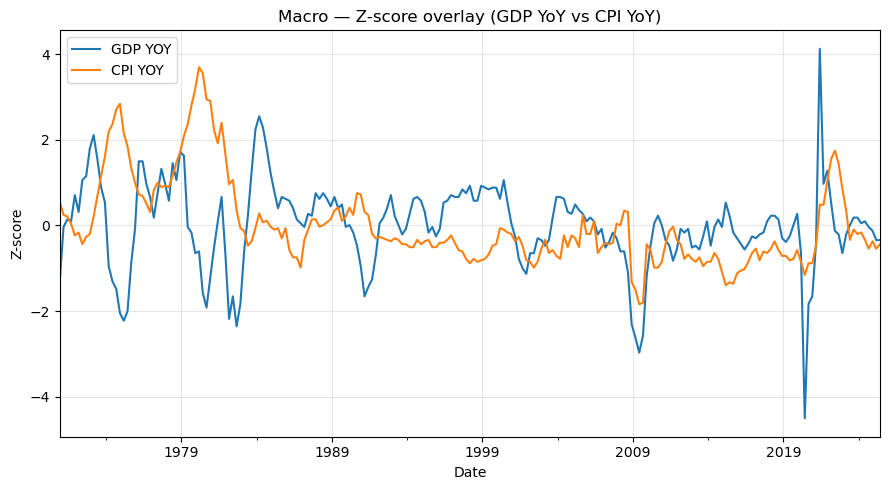

In [10]:
def zscore(df: pd.DataFrame) -> pd.DataFrame:
    return (df - df.mean()) / df.std(ddof=0)

macro_cols = [c for c in macro_m.columns if c.lower() in {"gdp yoy","cpi yoy"}]
if len(macro_cols) >= 2:
    m_z = zscore(macro_m[macro_cols].dropna(how="any"))
    ax = m_z.plot(figsize=(9,5))
    ax.set_title("Macro — Z-score overlay (GDP YoY vs CPI YoY)")
    ax.set_xlabel("Date"); ax.set_ylabel("Z-score"); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()


# Normalized-to-100 overlays (monthly)

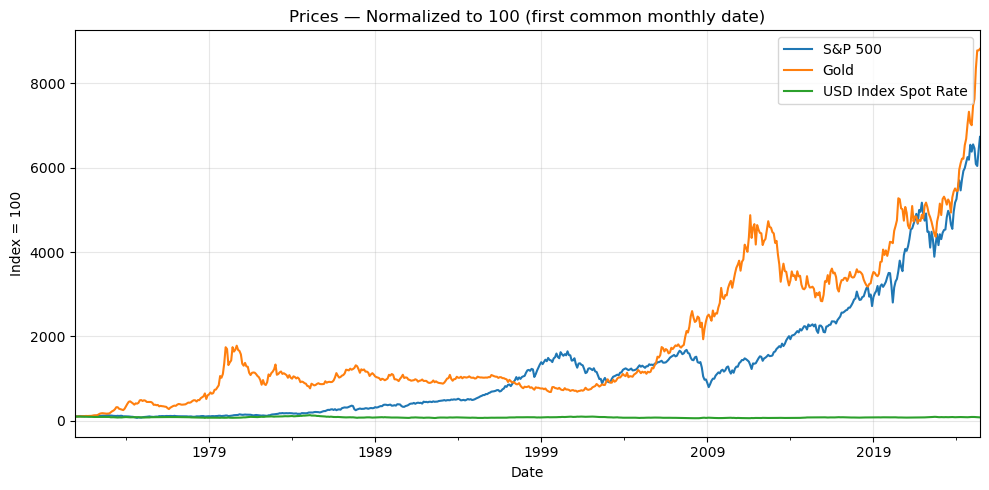

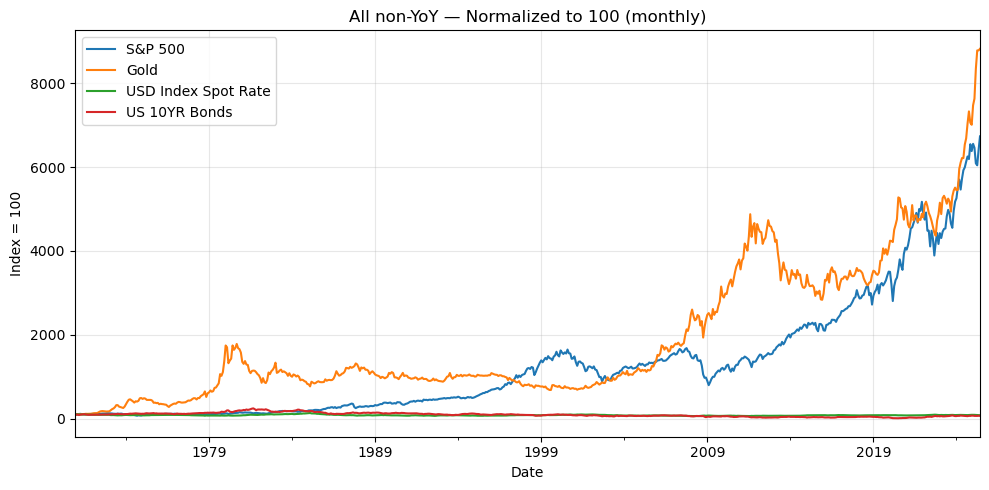

In [12]:
def to_100(df: pd.DataFrame) -> pd.DataFrame:
    sub = df.dropna(how="any").copy()
    if sub.empty: return sub
    return sub / sub.iloc[0] * 100

# Prices normalized at first common monthly date
p100 = to_100(prices_m)
if not p100.empty:
    ax = p100.plot(figsize=(10,5))
    ax.set_title("Prices — Normalized to 100 (first common monthly date)")
    ax.set_xlabel("Date"); ax.set_ylabel("Index = 100"); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

# All non-YoY (Prices + 10Y) normalized together
all_non_yoy_100 = to_100(combined_m)
if not all_non_yoy_100.empty and len(all_non_yoy_100.columns) > 1:
    ax = all_non_yoy_100.plot(figsize=(10,5))
    ax.set_title("All non-YoY — Normalized to 100 (monthly)")
    ax.set_xlabel("Date"); ax.set_ylabel("Index = 100"); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()


# Correlations: prices=log returns; yields/YoY=first differences

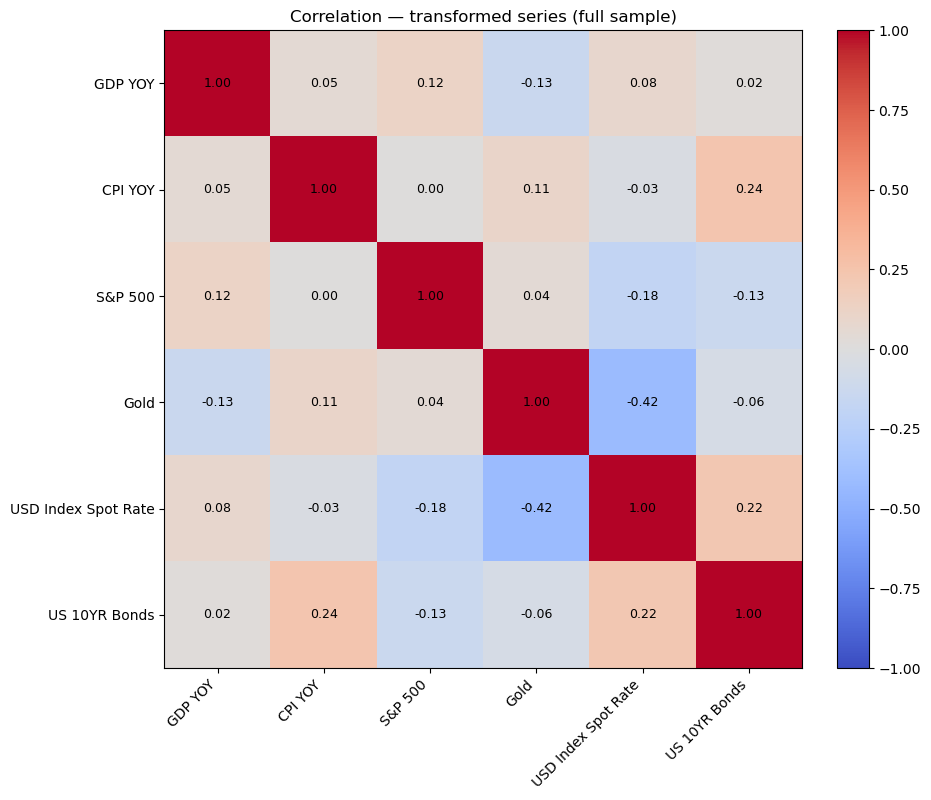

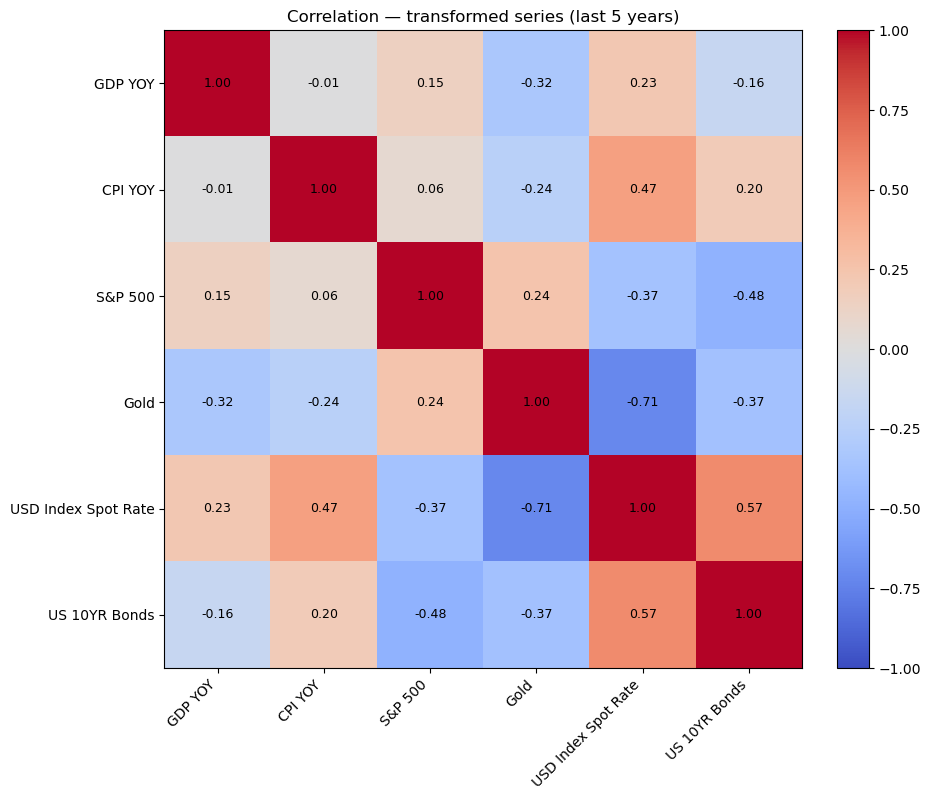

In [14]:
def log_ret(s: pd.Series):
    s = s.dropna()
    s = s[s > 0]
    return np.log(s).diff()

def first_diff(s: pd.Series):
    return s.dropna().diff()

def transform_for_corr(name: str, s: pd.Series):
    n = name.lower()
    return first_diff(s) if ("yoy" in n or "yield" in n or "bond" in n) else log_ret(s)

tx = pd.DataFrame({
    c: transform_for_corr(c, combined_all_m[c])
    for c in combined_all_m.columns
    if pd.api.types.is_numeric_dtype(combined_all_m[c])
}).dropna(how="all")

def heatmap(corr: pd.DataFrame, title: str):
    if corr is None or corr.empty: return
    fig, ax = plt.subplots(figsize=(8 + 0.35*len(corr.columns), 6 + 0.35*len(corr.columns)))
    im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_title(title)
    ax.set_xticks(range(len(corr.columns))); ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right"); ax.set_yticklabels(corr.index)
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

corr_full = tx.dropna(how="any").corr()
heatmap(corr_full, "Correlation — transformed series (full sample)")

if not tx.empty and pd.notna(tx.index.max()):
    cutoff = tx.index.max() - pd.DateOffset(years=5)
    corr_recent = tx.loc[tx.index >= cutoff].dropna(how="any").corr()
    heatmap(corr_recent, "Correlation — transformed series (last 5 years)")


# 24M rolling correlations 

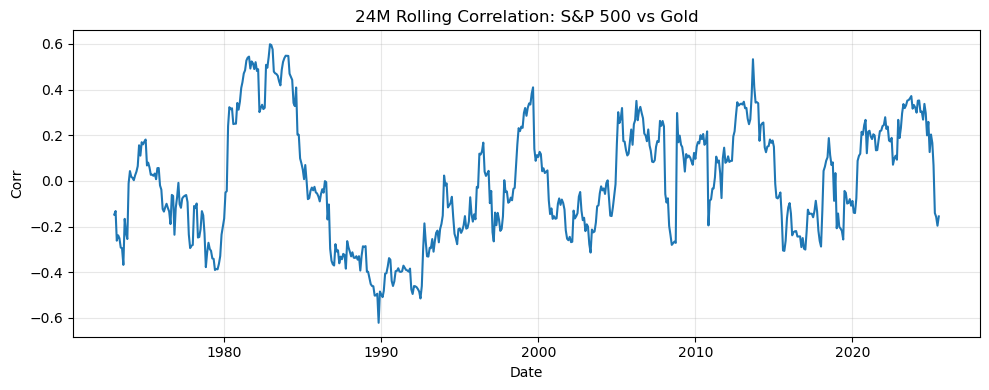

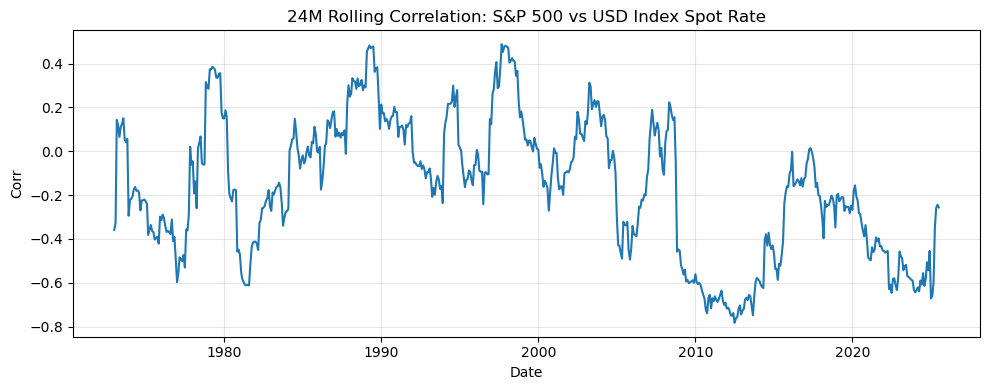

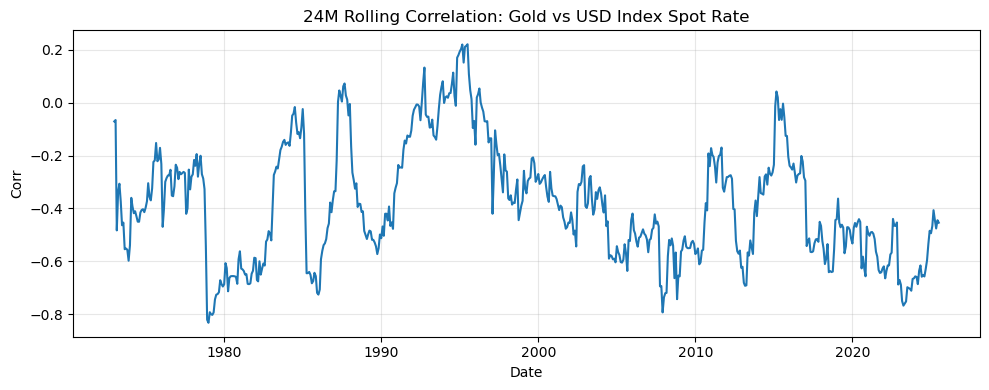

In [16]:
def rolling_corr(df, a, b, window=24):
    d = df[[a, b]].dropna(how="any")
    if d.empty: return pd.Series(dtype=float)
    return d[a].rolling(window).corr(d[b])

pairs = [
    ("S&P 500", "Gold"),
    ("S&P 500", "USD Index Spot Rate"),
    ("Gold", "USD Index Spot Rate"),
]
for a, b in pairs:
    if a in tx.columns and b in tx.columns:
        rc = rolling_corr(tx, a, b)
        if not rc.empty:
            plt.figure(figsize=(10,4))
            plt.plot(rc.index, rc.values)
            plt.title(f"24M Rolling Correlation: {a} vs {b}")
            plt.xlabel("Date"); plt.ylabel("Corr"); plt.grid(True, alpha=0.3)
            plt.tight_layout(); plt.show()


# Regime tagging + performance by regime

S&P 500                      Gold                  \
                         mean       std count      mean       std count   
HighInfl-HighGrowth  0.011784  0.030654    62  0.009395  0.056510    62   
HighInfl-LowGrowth  -0.016816  0.045257    42  0.003743  0.087252    42   
LowInfl-HighGrowth   0.008113  0.036195    49  0.010280  0.042896    49   
LowInfl-LowGrowth    0.006414  0.044341    65  0.001784  0.045756    65   

                    US 10YR Bonds (≈-Δyld)                  
                                      mean       std count  
HighInfl-HighGrowth              -0.017806  0.272001    62  
HighInfl-LowGrowth                0.006140  0.361759    42  
LowInfl-HighGrowth                0.043759  0.281980    49  
LowInfl-LowGrowth                 0.004023  0.268068    65

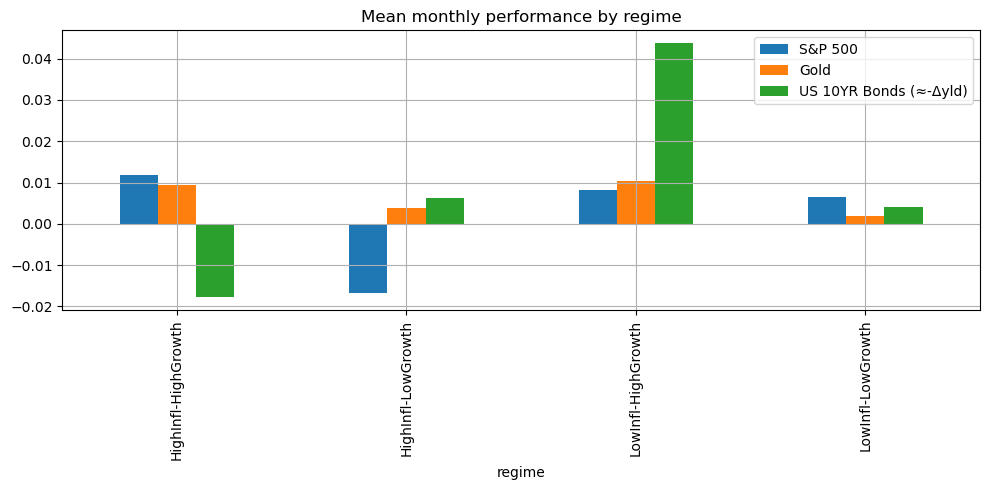

In [18]:
cpi = macro_m.get("CPI YOY")
gdp = macro_m.get("GDP YOY")

if cpi is not None and gdp is not None:
    cpi_thr = cpi.median()
    gdp_thr = gdp.median()

    regime = pd.Series(index=macro_m.index, dtype="object")
    regime[(cpi>=cpi_thr) & (gdp>=gdp_thr)] = "HighInfl-HighGrowth"
    regime[(cpi>=cpi_thr) & (gdp< gdp_thr)] = "HighInfl-LowGrowth"
    regime[(cpi< cpi_thr) & (gdp>=gdp_thr)] = "LowInfl-HighGrowth"
    regime[(cpi< cpi_thr) & (gdp< gdp_thr)] = "LowInfl-LowGrowth"

    # Asset transforms for performance
    rets = pd.DataFrame({
        "S&P 500": log_ret(prices_m["S&P 500"]),
        "Gold":    log_ret(prices_m["Gold"]),
        # Bonds proxy: negative yield change (directionally)
        "US 10YR Bonds (≈-Δyld)": -first_diff(yield_m["US 10YR Bonds"]),
    }).dropna(how="any")

    reg = regime.reindex(rets.index)
    perf = rets.groupby(reg).agg(['mean','std','count']).sort_index()
    display(perf)

    means = rets.join(reg.rename("regime")).groupby("regime").mean()
    means.plot(kind="bar", figsize=(10,5), grid=True, title="Mean monthly performance by regime")
    plt.tight_layout(); plt.show()


# Hedge optimizer per regime (minimize S&P 500 portfolio volatility)
# Portfolio: 1 * S&P + w_g * Gold + w_b * BondsProxy, bounds [0, 1]

In [20]:
def min_var_weights(returns: pd.DataFrame, grid=101):
    # grid search 0..1 in 1/(grid-1) steps (fast, simple)
    best = {"wg":0.0, "wb":0.0, "vol":np.inf}
    for wg in np.linspace(0,1,grid):
        for wb in np.linspace(0,1,grid):
            port = returns["S&P 500"] + wg*returns["Gold"] + wb*returns["US 10YR Bonds (≈-Δyld)"]
            v = port.std(ddof=0)
            if np.isfinite(v) and v < best["vol"]:
                best = {"wg":float(wg), "wb":float(wb), "vol":float(v)}
    return best

# Prepare monthly returns / proxies (same as in Slot 7)
rets_all = pd.DataFrame({
    "S&P 500": log_ret(prices_m["S&P 500"]),
    "Gold":    log_ret(prices_m["Gold"]),
    "US 10YR Bonds (≈-Δyld)": -first_diff(yield_m["US 10YR Bonds"]),
}).dropna(how="any")

if 'regime' in locals():
    reg_idx = regime.reindex(rets_all.index)
    results = {}
    for r in sorted(reg_idx.dropna().unique()):
        subset = rets_all.loc[reg_idx == r]
        if subset.shape[0] > 24:  # need enough data
            opt = min_var_weights(subset, grid=101)
            port = subset["S&P 500"] + opt["wg"]*subset["Gold"] + opt["wb"]*subset["US 10YR Bonds (≈-Δyld)"]
            sharpe = port.mean() / port.std(ddof=0) if port.std(ddof=0) != 0 else np.nan
            results[r] = {"w_gold": opt["wg"], "w_bonds": opt["wb"], "vol": opt["vol"], "sharpe": sharpe, "n": subset.shape[0]}
    pd.DataFrame(results).T


In [21]:
combined_all_m.to_csv("combined_monthly_clean.csv")
print("Saved combined_monthly_clean.csv")


Saved combined_monthly_clean.csv


# Feature engineering (monthly returns, UST total‑return proxy, spreads)

In [23]:
import numpy as np

# --- Resample to month-end for stability ---
macro_m  = dfs["Macro"].set_index("Date").resample("ME").last()
prices_m = dfs["Prices"].set_index("Date").resample("ME").last()
yield_m  = dfs["Yield"].set_index("Date").resample("ME").last()

def logret(s): 
    return np.log(s).diff()

# Core series
spx  = prices_m["S&P 500"].astype(float)
gold = prices_m["Gold"].astype(float)
u10  = yield_m["US 10YR Bonds"].astype(float) / 100.0  # to decimal

# Monthly log returns for SPX/Gold
spx_ret  = logret(spx).rename("SPX_ret")
gold_ret = logret(gold).rename("Gold_ret")

# UST total-return approximation from 10y yield (carry − D*Δy + 0.5*C*Δy²)
D_eff, C_eff = 7.5, 0.9
dy = u10.diff()
ust_ret = (u10.shift(1)/12.0 - D_eff*dy + 0.5*C_eff*(dy**2)).rename("UST_ret")

# Yield-curve spreads (use what exists)
yc_cols = yield_m.columns.str.upper().tolist()
ten = "US 10YR BONDS"
two = next((c for c in yield_m.columns if "2" in c and "YR" in c.upper()), None)
three_m = next((c for c in yield_m.columns if ("3" in c and "M" in c.upper()) or "3M" in c.upper()), None)

sp_2s10s = None
sp_3m10y = None
if two is not None:
    sp_2s10s = (yield_m["US 10YR Bonds"] - yield_m[two]).rename("2s10s").resample("M").last()
if three_m is not None:
    sp_3m10y = (yield_m["US 10YR Bonds"] - yield_m[three_m]).rename("3m10y").resample("M").last()

# CPI/GDP YoY from Macro (already YoY in your file)
cpi_yoy = macro_m.get("CPI YOY")
gdp_yoy = macro_m.get("GDP YOY")

# Merge working DataFrame
data = (
    pd.concat([spx_ret, gold_ret, ust_ret, cpi_yoy, gdp_yoy], axis=1)
      .dropna(subset=["SPX_ret","Gold_ret","UST_ret"])
      .rename(columns={"CPI YOY":"CPI_YoY", "GDP YOY":"GDP_YoY"})
)


# Rolling correlations & quick overlays

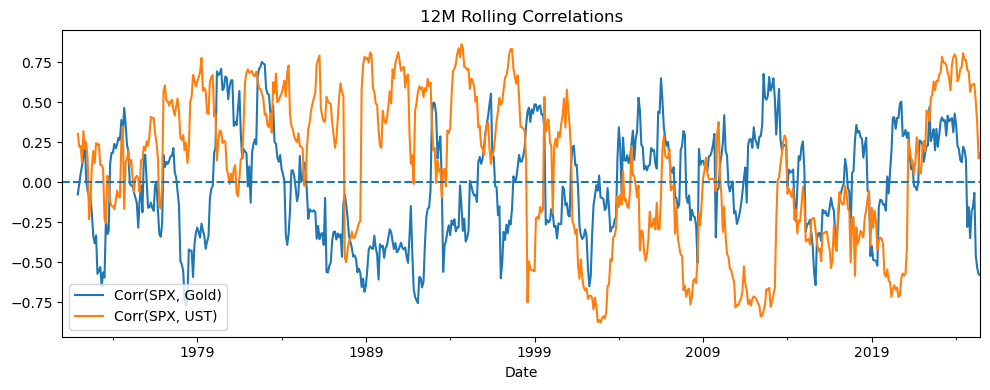

In [25]:
# 12m rolling correlations of SPX vs Gold/UST
win = 12
rc_spx_gold = data["SPX_ret"].rolling(win).corr(data["Gold_ret"])
rc_spx_ust  = data["SPX_ret"].rolling(win).corr(data["UST_ret"])

plt.figure(figsize=(10,4))
rc_spx_gold.plot(label="Corr(SPX, Gold)")
rc_spx_ust.plot(label="Corr(SPX, UST)")
plt.axhline(0, linestyle="--")
plt.title("12M Rolling Correlations")
plt.legend(); plt.tight_layout(); plt.show()

# Yield spreads with inversion line
if sp_2s10s is not None:
    plt.figure(figsize=(10,4))
    sp_2s10s.plot()
    plt.axhline(0, linestyle="--")
    plt.title("2s10s (10Y - 2Y)"); plt.tight_layout(); plt.show()

if sp_3m10y is not None:
    plt.figure(figsize=(10,4))
    sp_3m10y.plot()
    plt.axhline(0, linestyle="--")
    plt.title("3m10y (10Y - 3M)"); plt.tight_layout(); plt.show()


# Macro regimes (Growth↑/↓ × Inflation↑/↓), timeline & counts

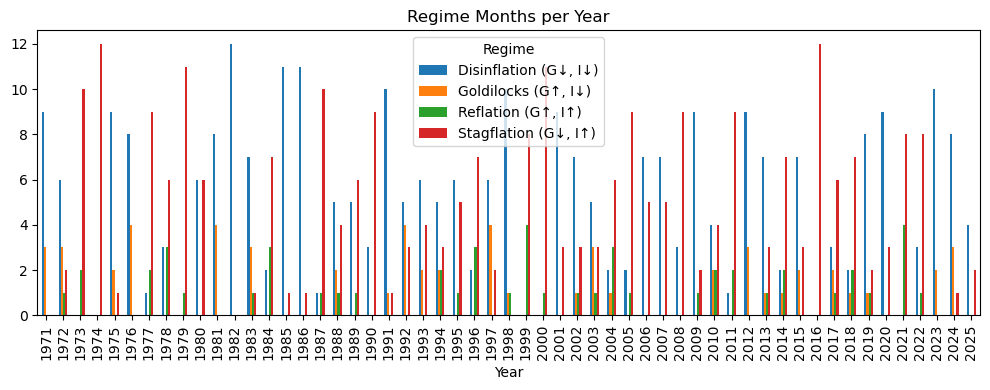

In [27]:
def regime_label(infl_up, grow_up):
    if grow_up and not infl_up: return "Goldilocks (G↑, I↓)"
    if grow_up and infl_up:     return "Reflation (G↑, I↑)"
    if (not grow_up) and infl_up: return "Stagflation (G↓, I↑)"
    return "Disinflation (G↓, I↓)"

infl_up  = (data["CPI_YoY"] > data["CPI_YoY"].rolling(12, min_periods=1).mean())
grow_up  = (data["GDP_YoY"] > data["GDP_YoY"].rolling(24, min_periods=1).mean())
data["Regime"] = [regime_label(i,g) for i,g in zip(infl_up, grow_up)]

# Timeline counts per year
tline = data.copy()
tline["Year"] = tline.index.year
counts = tline.pivot_table(index="Year", columns="Regime", values="SPX_ret", aggfunc="count").fillna(0)
counts.plot(kind="bar", figsize=(10,4), title="Regime Months per Year"); plt.tight_layout(); plt.show()


# Variance‑min hedge, plus CVaR & MaxDD alternatives (per regime)

In [29]:
# Core optimizer: given w (gold weight in hedge basket), compute gamma* and hedged series
def optimize_given_w(S, gold, ust, w):
    H = w*gold + (1-w)*ust
    varH = H.var()
    if varH <= 1e-12:
        return np.nan, None
    cov_SH = np.cov(pd.concat([S,H], axis=1).dropna().values.T, ddof=0)[0,1]
    gamma = - cov_SH / varH
    hedged = S + gamma*H
    return float(gamma), hedged

def ann(ret):
    r = ret.dropna()
    if r.empty: return np.nan
    return (1+r).prod()**(12/len(r)) - 1

def max_dd(ret):
    cum = (1+ret).cumprod()
    peak = cum.cummax()
    return float((cum/peak - 1).min())

def cvar(ret, alpha=0.05):
    r = ret.dropna()
    if r.empty: return np.nan
    q = np.quantile(r, alpha)
    tail = r[r<=q]
    return float(tail.mean()) if len(tail)>0 else 0.0

ws = np.linspace(0,1,51)
rows = []
for regime, grp in data.groupby("Regime"):
    sr = grp[["SPX_ret","Gold_ret","UST_ret"]].dropna()
    if len(sr) < 24: 
        continue
    S, G, U = sr["SPX_ret"], sr["Gold_ret"], sr["UST_ret"]
    base_var = S.var()
    best_var = (np.inf, None, None)   # var, w, gamma
    best_mdd = (np.inf, None, None)   # |dd|, w, gamma
    best_cvr = (-np.inf, None, None)  # CVaR (maximize), w, gamma

    for w in ws:
        gamma, hedged = optimize_given_w(S,G,U,w)
        if hedged is None: 
            continue
        v  = hedged.var()
        dd = max_dd(hedged)
        cv = cvar(hedged, 0.05)

        if v < best_var[0]:                      best_var = (v, w, gamma)
        if abs(dd) < abs(best_mdd[0]):           best_mdd = (dd, w, gamma)
        if cv > best_cvr[0]:                     best_cvr = (cv, w, gamma)

    def metrics_for(w, gamma):
        _, hedged = optimize_given_w(S,G,U,w)
        return {
            "Hedged_ann": ann(hedged),
            "Hedged_vol": hedged.std()*np.sqrt(12),
            "Hedged_maxDD": max_dd(hedged),
            "Hedged_CVaR5": cvar(hedged, 0.05),
            "Var_reduction_%": 100*(base_var - hedged.var())/base_var if base_var>0 else np.nan
        }

    met_var = metrics_for(best_var[1], best_var[2])
    met_dd  = metrics_for(best_mdd[1], best_mdd[2])
    met_cv  = metrics_for(best_cvr[1], best_cvr[2])

    rows.append({
        "Regime": regime,
        "VAR_w_gold": best_var[1], "VAR_gamma": best_var[2], **{f"VAR_{k}":v for k,v in met_var.items()},
        "MDD_w_gold": best_mdd[1], "MDD_gamma": best_mdd[2], **{f"MDD_{k}":v for k,v in met_dd.items()},
        "CVaR_w_gold": best_cvr[1], "CVaR_gamma": best_cvr[2], **{f"CVaR_{k}":v for k,v in met_cv.items()},
    })

opt_table = pd.DataFrame(rows).set_index("Regime").round(4)
display(opt_table)


VAR_w_gold  VAR_gamma  VAR_Hedged_ann  VAR_Hedged_vol  \
Regime                                                                         
Disinflation (G↓, I↓)        0.24    -0.1875          0.1029          0.1549   
Goldilocks (G↑, I↓)          0.08    -0.4784          0.0881          0.1272   
Reflation (G↑, I↑)           0.86     0.1651          0.1566          0.1012   
Stagflation (G↓, I↑)         0.10    -0.2089         -0.0226          0.1599   

                       VAR_Hedged_maxDD  VAR_Hedged_CVaR5  \
Regime                                                      
Disinflation (G↓, I↓)           -0.4160           -0.0998   
Goldilocks (G↑, I↓)             -0.1518           -0.0729   
Reflation (G↑, I↑)              -0.0715           -0.0513   
Stagflation (G↓, I↑)            -0.5764           -0.1125   

                       VAR_Var_reduction_%  MDD_w_gold  MDD_gamma  \
Regime                                                              
Disinflation (G↓, I↓)               1.1211        1.00    -0.0561   
Goldilocks (G↑, I↓)                 7.7241        1.00    -0.0720   
Reflation (G↑, I↑)                  7.1418        0.24     0.3130   
Stagflation (G↓, I↑)                1.0952        1.00    -0.0193   

                       MDD_Hedged_ann  ...  MDD_Hedged_maxDD  \
Regime                                 ...                     
Disinflation (G↓, I↓)          0.1150  ...           -0.4065   
Goldilocks (G↑, I↓)            0.1145  ...           -0.1190   
Reflation (G↑, I↑)             0.1526  ...           -0.0672   
Stagflation (G↓, I↑)          -0.0124  ...           -0.5420   

                       MDD_Hedged_CVaR5  MDD_Var_reduction_%  CVaR_w_gold  \
Regime                                                                      
Disinflation (G↓, I↓)           -0.0979               0.3754         1.00   
Goldilocks (G↑, I↓)             -0.0745               0.7646         0.12   
Reflation (G↑, I↑)              -0.0495               4.2465         0.32   
Stagflation (G↓, I↑)            -0.1117               0.0625         0.50   

                       CVaR_gamma  CVaR_Hedged_ann  CVaR_Hedged_vol  \
Regime                                                                
Disinflation (G↓, I↓)     -0.0561           0.1150           0.1555   
Goldilocks (G↑, I↓)       -0.4816           0.0884           0.1273   
Reflation (G↑, I↑)         0.3122           0.1543           0.1022   
Stagflation (G↓, I↑)      -0.0887          -0.0182           0.1605   

                       CVaR_Hedged_maxDD  CVaR_Hedged_CVaR5  \
Regime                                                        
Disinflation (G↓, I↓)            -0.4065            -0.0979   
Goldilocks (G↑, I↓)              -0.1501            -0.0729   
Reflation (G↑, I↑)               -0.0675            -0.0493   
Stagflation (G↓, I↑)             -0.5739            -0.1117   

                       CVaR_Var_reduction_%  
Regime                                       
Disinflation (G↓, I↓)                0.3754  
Goldilocks (G↑, I↓)                  7.6606  
Reflation (G↑, I↑)                   5.4320  
Stagflation (G↓, I↑)                 0.3863  

[4 rows x 21 columns]

# Heatmap: variance reduction vs gold weight by regime

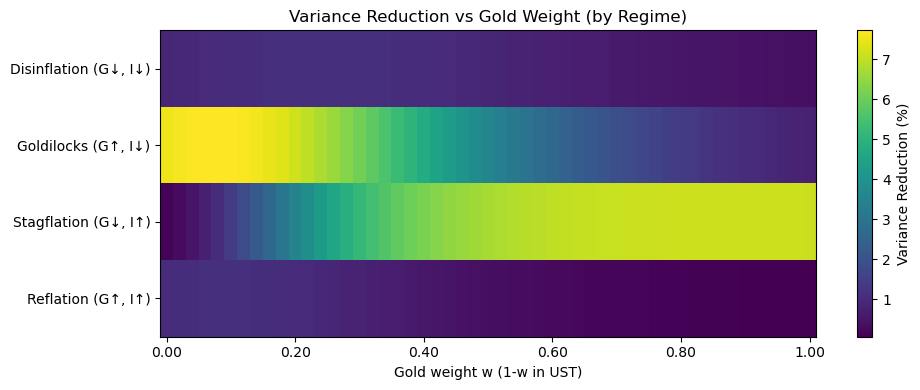

In [31]:
# Heatmap of variance reduction across w
regimes = list(data["Regime"].dropna().unique())
heat = []
for regime, grp in data.groupby("Regime"):
    sr = grp[["SPX_ret","Gold_ret","UST_ret"]].dropna()
    if len(sr) < 24:
        heat.append([np.nan]*len(ws)); continue
    S,G,U = sr["SPX_ret"], sr["Gold_ret"], sr["UST_ret"]
    base_var = S.var()
    row=[]
    for w in ws:
        gamma, hedged = optimize_given_w(S,G,U,w)
        if hedged is None:
            row.append(np.nan)
        else:
            row.append(100*(base_var-hedged.var())/base_var if base_var>0 else np.nan)
    heat.append(row)

plt.figure(figsize=(10,4))
plt.imshow(np.array(heat), aspect="auto", interpolation="nearest")
plt.colorbar(label="Variance Reduction (%)")
plt.yticks(range(len(regimes)), regimes)
xt = [0,10,20,30,40,50]
plt.xticks(xt, [f"{ws[i]:.2f}" for i in xt])
plt.title("Variance Reduction vs Gold Weight (by Regime)")
plt.xlabel("Gold weight w (1-w in UST)"); plt.tight_layout(); plt.show()


# w–γ–Variance surface (for latest regime)

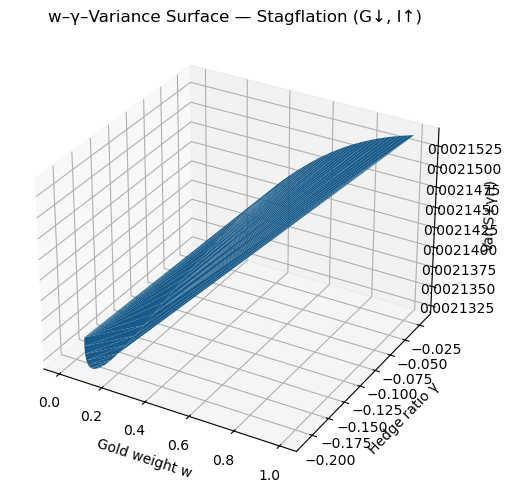

In [33]:
from mpl_toolkits.mplot3d import Axes3D  

last_regime = data["Regime"].dropna().iloc[-1]
sr = data[data["Regime"]==last_regime][["SPX_ret","Gold_ret","UST_ret"]].dropna()
if len(sr) >= 24:
    S,G,U = sr["SPX_ret"], sr["Gold_ret"], sr["UST_ret"]
    W, Gam, Var = [], [], []
    for w in ws:
        gamma, hedged = optimize_given_w(S,G,U,w)
        if hedged is None: continue
        W.append(w); Gam.append(gamma); Var.append(hedged.var())

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(np.array(W), np.array(Gam), np.array(Var))
    ax.set_xlabel("Gold weight w"); ax.set_ylabel("Hedge ratio γ"); ax.set_zlabel("Var(S+γH)")
    plt.title(f"w–γ–Variance Surface — {last_regime}")
    plt.tight_layout(); plt.show()


# Hedged vs unhedged cumulative returns (by regime best‑w)

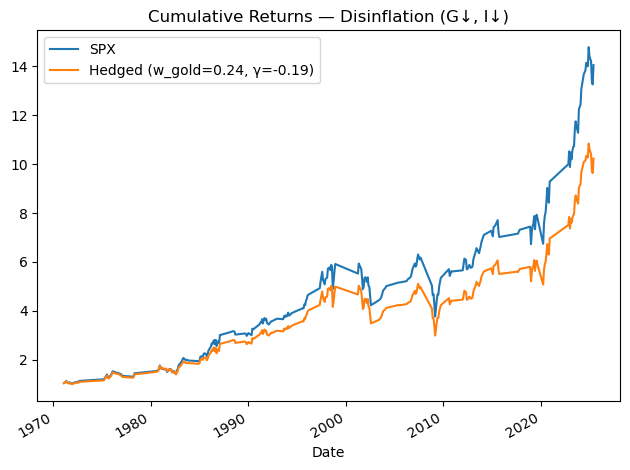

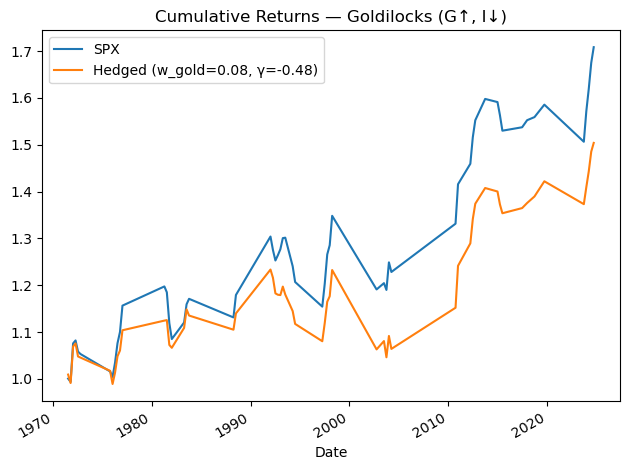

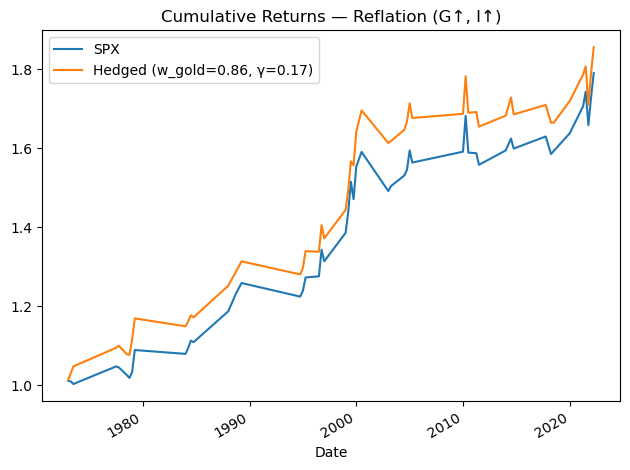

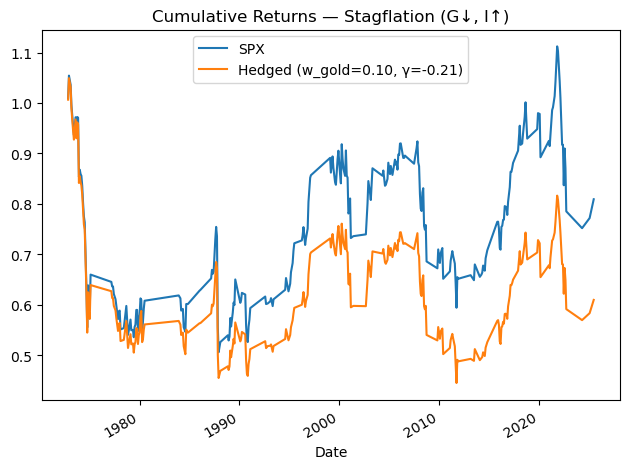

In [35]:
# Show hedged vs unhedged in each regime using the variance-min solution
for regime, grp in data.groupby("Regime"):
    sr = grp[["SPX_ret","Gold_ret","UST_ret"]].dropna()
    if len(sr) < 24: 
        continue
    S,G,U = sr["SPX_ret"], sr["Gold_ret"], sr["UST_ret"]
    # find best variance w
    best = (np.inf, None, None)
    for w in ws:
        gamma, hedged = optimize_given_w(S,G,U,w)
        if hedged is None: continue
        v = hedged.var()
        if v < best[0]:
            best = (v, w, gamma)
    # plot
    _, hedged = optimize_given_w(S,G,U,best[1])
    (1+S).cumprod().plot(label="SPX")
    (1+hedged).cumprod().plot(label=f"Hedged (w_gold={best[1]:.2f}, γ={best[2]:.2f})")
    plt.title(f"Cumulative Returns — {regime}")
    plt.legend(); plt.tight_layout(); plt.show()


# Insights!

In [37]:
def last_non_na(s):
    s = s.dropna()
    return None if s.empty else float(s.iloc[-1])

print("— Macro/Hedge Analysis —")
print(f"Latest CPI YoY: {last_non_na(data['CPI_YoY']):.2f}%   | GDP YoY: {last_non_na(data['GDP_YoY']):.2f}%")
if sp_2s10s is not None: print(f"2s10s spread: {last_non_na(sp_2s10s.loc[data.index]):.2f} bps")
if sp_3m10y is not None: print(f"3m10y spread: {last_non_na(sp_3m10y.loc[data.index]):.2f} bps")
print(f"Rolling Corr(SPX, Gold) 12m: {last_non_na(rc_spx_gold):.2f} | Corr(SPX, UST) 12m: {last_non_na(rc_spx_ust):.2f}")
print(f"Latest regime: {data['Regime'].dropna().iloc[-1]}")


— Macro/Hedge Analysis —
Latest CPI YoY: 2.70%   | GDP YoY: 2.00%
Rolling Corr(SPX, Gold) 12m: -0.58 | Corr(SPX, UST) 12m: 0.18
Latest regime: Stagflation (G↓, I↑)


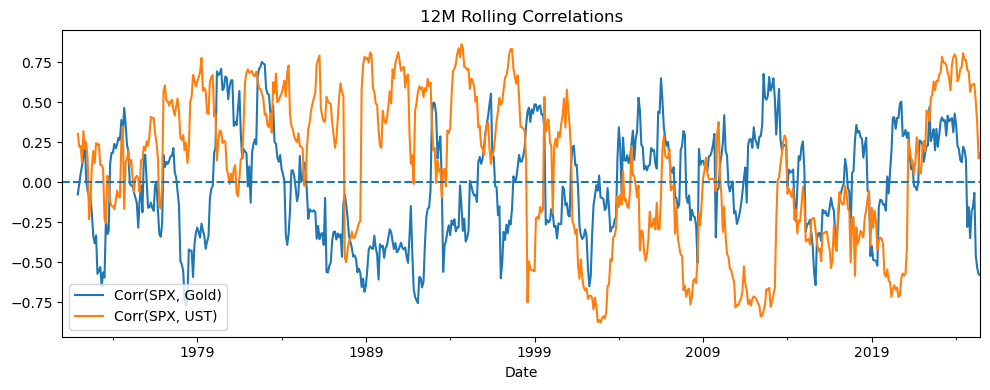

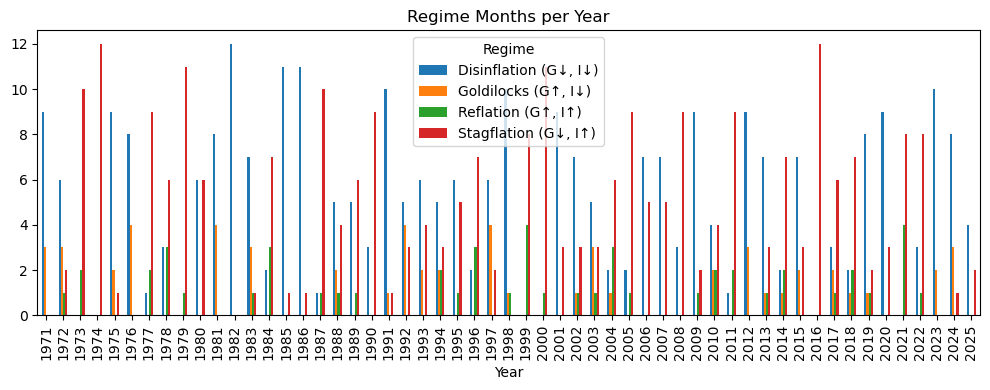

VAR_w   VAR_γ  VAR_Ann  VAR_Vol  VAR_MaxDD  VAR_CVaR5  \
Regime                                                                         
Disinflation (G↓, I↓)   0.24 -0.1875   0.1029   0.1549    -0.4160    -0.0998   
Goldilocks (G↑, I↓)     0.08 -0.4784   0.0881   0.1272    -0.1518    -0.0729   
Reflation (G↑, I↑)      0.86  0.1651   0.1566   0.1012    -0.0715    -0.0513   
Stagflation (G↓, I↑)    0.10 -0.2089  -0.0226   0.1599    -0.5764    -0.1125   

                       VAR_VarRed%  MDD_w   MDD_γ  MDD_Ann  ...  MDD_MaxDD  \
Regime                                                      ...              
Disinflation (G↓, I↓)       1.1211   1.00 -0.0561   0.1150  ...    -0.4065   
Goldilocks (G↑, I↓)         7.7241   1.00 -0.0720   0.1145  ...    -0.1190   
Reflation (G↑, I↑)          7.1418   0.24  0.3130   0.1526  ...    -0.0672   
Stagflation (G↓, I↑)        1.0952   1.00 -0.0193  -0.0124  ...    -0.5420   

                       MDD_CVaR5  MDD_VarRed%  CVaR_w  CVaR_γ  CVaR_Ann  \
Regime                                                                    
Disinflation (G↓, I↓)    -0.0979       0.3754    1.00 -0.0561    0.1150   
Goldilocks (G↑, I↓)      -0.0745       0.7646    0.12 -0.4816    0.0884   
Reflation (G↑, I↑)       -0.0495       4.2465    0.32  0.3122    0.1543   
Stagflation (G↓, I↑)     -0.1117       0.0625    0.50 -0.0887   -0.0182   

                       CVaR_Vol  CVaR_MaxDD  CVaR_CVaR5  CVaR_VarRed%  
Regime                                                                 
Disinflation (G↓, I↓)    0.1555     -0.4065     -0.0979        0.3754  
Goldilocks (G↑, I↓)      0.1273     -0.1501     -0.0729        7.6606  
Reflation (G↑, I↑)       0.1022     -0.0675     -0.0493        5.4320  
Stagflation (G↓, I↑)     0.1605     -0.5739     -0.1117        0.3863  

[4 rows x 21 columns]

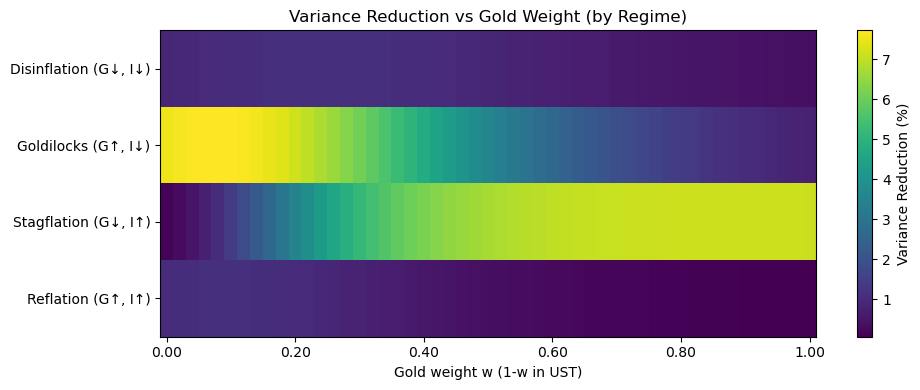

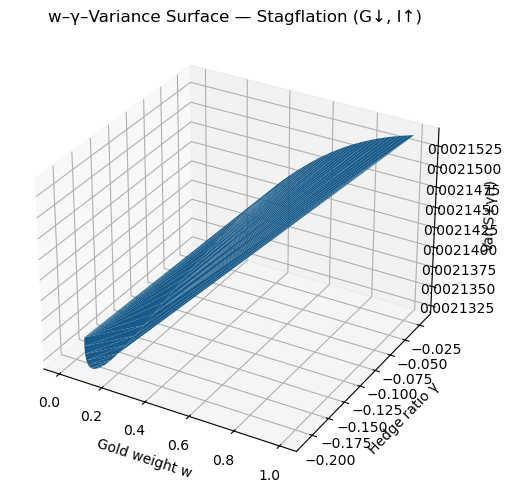

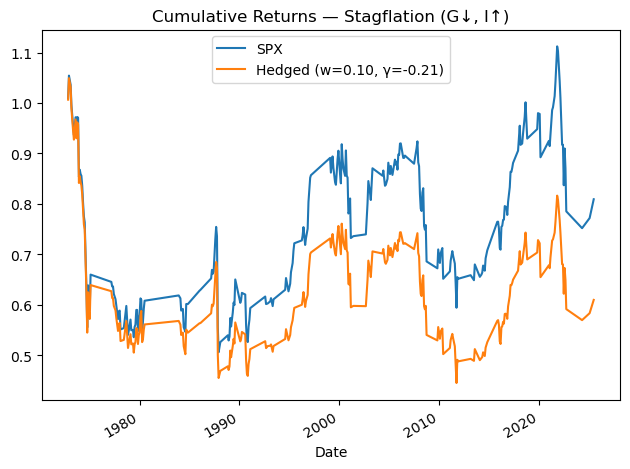

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

def run_dashboard():
    # 1) Rolling correlations
    win = 12
    rc_spx_gold = data["SPX_ret"].rolling(win).corr(data["Gold_ret"])
    rc_spx_ust  = data["SPX_ret"].rolling(win).corr(data["UST_ret"])
    plt.figure(figsize=(10,4))
    rc_spx_gold.plot(label="Corr(SPX, Gold)")
    rc_spx_ust.plot(label="Corr(SPX, UST)")
    plt.axhline(0, linestyle="--")
    plt.title("12M Rolling Correlations")
    plt.legend(); plt.tight_layout(); plt.show()

    # 2) Yield‑curve spreads
    if 'sp_2s10s' in globals() and sp_2s10s is not None:
        plt.figure(figsize=(10,4))
        sp_2s10s.plot()
        plt.axhline(0, linestyle="--")
        plt.title("2s10s (10Y - 2Y)"); plt.tight_layout(); plt.show()

    if 'sp_3m10y' in globals() and sp_3m10y is not None:
        plt.figure(figsize=(10,4))
        sp_3m10y.plot()
        plt.axhline(0, linestyle="--")
        plt.title("3m10y (10Y - 3M)"); plt.tight_layout(); plt.show()

    # 3) Regime timeline counts
    tline = data.copy()
    tline["Year"] = tline.index.year
    counts = tline.pivot_table(index="Year", columns="Regime", values="SPX_ret", aggfunc="count").fillna(0)
    counts.plot(kind="bar", figsize=(10,4), title="Regime Months per Year"); plt.tight_layout(); plt.show()

    # 4) Hedge optimization summary table (Variance / MaxDD / CVaR)
    ws_local = np.linspace(0,1,51)
    rows = []
    for regime, grp in data.groupby("Regime"):
        sr = grp[["SPX_ret","Gold_ret","UST_ret"]].dropna()
        if len(sr) < 24: 
            continue
        S,G,U = sr["SPX_ret"], sr["Gold_ret"], sr["UST_ret"]
        base_var = S.var()
        best_var = (np.inf, None, None)
        best_mdd = (np.inf, None, None)
        best_cvr = (-np.inf, None, None)
        for w in ws_local:
            gamma, hedged = optimize_given_w(S,G,U,w)
            if hedged is None: 
                continue
            v  = hedged.var()
            dd = max_dd(hedged)
            cv = cvar(hedged, 0.05)
            if v < best_var[0]:            best_var = (v, w, gamma)
            if abs(dd) < abs(best_mdd[0]): best_mdd = (dd, w, gamma)
            if cv > best_cvr[0]:           best_cvr = (cv, w, gamma)
        def metrics_for(w, gamma):
            _, hedged = optimize_given_w(S,G,U,w)
            return {
                "Ann": ann(hedged),
                "Vol": hedged.std()*np.sqrt(12),
                "MaxDD": max_dd(hedged),
                "CVaR5": cvar(hedged, 0.05),
                "VarRed%": 100*(base_var - hedged.var())/base_var if base_var>0 else np.nan
            }
        mv = metrics_for(best_var[1], best_var[2])
        md = metrics_for(best_mdd[1], best_mdd[2])
        mc = metrics_for(best_cvr[1], best_cvr[2])
        rows.append({
            "Regime": regime,
            "VAR_w": best_var[1], "VAR_γ": best_var[2], **{f"VAR_{k}":v for k,v in mv.items()},
            "MDD_w": best_mdd[1], "MDD_γ": best_mdd[2], **{f"MDD_{k}":v for k,v in md.items()},
            "CVaR_w": best_cvr[1], "CVaR_γ": best_cvr[2], **{f"CVaR_{k}":v for k,v in mc.items()},
        })
    if rows:
        opt_tbl = pd.DataFrame(rows).set_index("Regime").round(4)
        display(opt_tbl)

    # 5) Heatmap of variance reduction vs w, by regime
    regimes = list(data["Regime"].dropna().unique())
    heat = []
    for regime, grp in data.groupby("Regime"):
        sr = grp[["SPX_ret","Gold_ret","UST_ret"]].dropna()
        if len(sr) < 24:
            heat.append([np.nan]*len(ws_local)); continue
        S,G,U = sr["SPX_ret"], sr["Gold_ret"], sr["UST_ret"]
        base_var = S.var()
        row=[]
        for w in ws_local:
            gamma, hedged = optimize_given_w(S,G,U,w)
            row.append(100*(base_var-hedged.var())/base_var if (hedged is not None and base_var>0) else np.nan)
        heat.append(row)
    plt.figure(figsize=(10,4))
    plt.imshow(np.array(heat), aspect="auto", interpolation="nearest")
    plt.colorbar(label="Variance Reduction (%)")
    xt = [0,10,20,30,40,50]
    plt.xticks(xt, [f"{ws_local[i]:.2f}" for i in xt])
    plt.yticks(range(len(regimes)), regimes)
    plt.title("Variance Reduction vs Gold Weight (by Regime)")
    plt.xlabel("Gold weight w (1-w in UST)"); plt.tight_layout(); plt.show()

    # 6) w–γ–Variance 3D surface (latest regime)
    last_regime = data["Regime"].dropna().iloc[-1]
    sr = data[data["Regime"]==last_regime][["SPX_ret","Gold_ret","UST_ret"]].dropna()
    if len(sr) >= 24:
        S,G,U = sr["SPX_ret"], sr["Gold_ret"], sr["UST_ret"]
        W, Gam, Var = [], [], []
        for w in ws_local:
            gamma, hedged = optimize_given_w(S,G,U,w)
            if hedged is None: continue
            W.append(w); Gam.append(gamma); Var.append(hedged.var())
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_trisurf(np.array(W), np.array(Gam), np.array(Var))
        ax.set_xlabel("Gold weight w"); ax.set_ylabel("Hedge ratio γ"); ax.set_zlabel("Var(S+γH)")
        plt.title(f"w–γ–Variance Surface — {last_regime}")
        plt.tight_layout(); plt.show()

    # 7) Hedged vs Unhedged (best‑variance in latest regime)
    if len(sr) >= 24:
        # find best-variance w
        best = (np.inf, None, None)
        for w in ws_local:
            gamma, hedged = optimize_given_w(S,G,U,w)
            if hedged is None: continue
            v = hedged.var()
            if v < best[0]:
                best = (v, w, gamma)
        _, hedged = optimize_given_w(S,G,U,best[1])
        (1+S).cumprod().plot(label="SPX")
        (1+hedged).cumprod().plot(label=f"Hedged (w={best[1]:.2f}, γ={best[2]:.2f})")
        plt.title(f"Cumulative Returns — {last_regime}")
        plt.legend(); plt.tight_layout(); plt.show()


run_dashboard()


# Pull IBKR API

Connected. Server time: 2025-08-20 04:02:44+00:00
Resolved 18/18 contracts.
SPY: 1995-08-28 → 2025-08-19 (7542 rows)
XLU: 1998-12-22 → 2025-08-19 (6704 rows)
XLP: 1998-12-22 → 2025-08-19 (6704 rows)
XLV: 1998-12-22 → 2025-08-19 (6704 rows)
XLC: 2018-06-19 → 2025-08-19 (1802 rows)
XLK: 1998-12-22 → 2025-08-19 (6704 rows)
XLY: 1998-12-22 → 2025-08-19 (6704 rows)
XLI: 1998-12-22 → 2025-08-19 (6703 rows)
XLE: 1998-12-22 → 2025-08-19 (6704 rows)
XLB: 1998-12-22 → 2025-08-19 (6704 rows)
XLRE: 2015-10-08 → 2025-08-19 (2473 rows)
GLD: 2004-11-18 → 2025-08-19 (5218 rows)
UUP: 2007-02-20 → 2025-08-19 (4649 rows)
IEF: 2017-08-03 → 2025-08-19 (2022 rows)
TLT: 2016-02-03 → 2025-08-19 (2400 rows)
EURUSD: 2005-03-09 → 2025-08-20 (5304 rows)
USDJPY: 2005-03-09 → 2025-08-20 (5304 rows)
USDCHF: 2005-03-09 → 2025-08-20 (5304 rows)
Merge complete. #rows, #cols: (657, 24)
Sample IBKR cols: ['SPY', 'XLU', 'XLP', 'XLV', 'GLD', 'UUP', 'IEF', 'TLT', 'EURUSD', 'USDJPY', 'USDCHF']


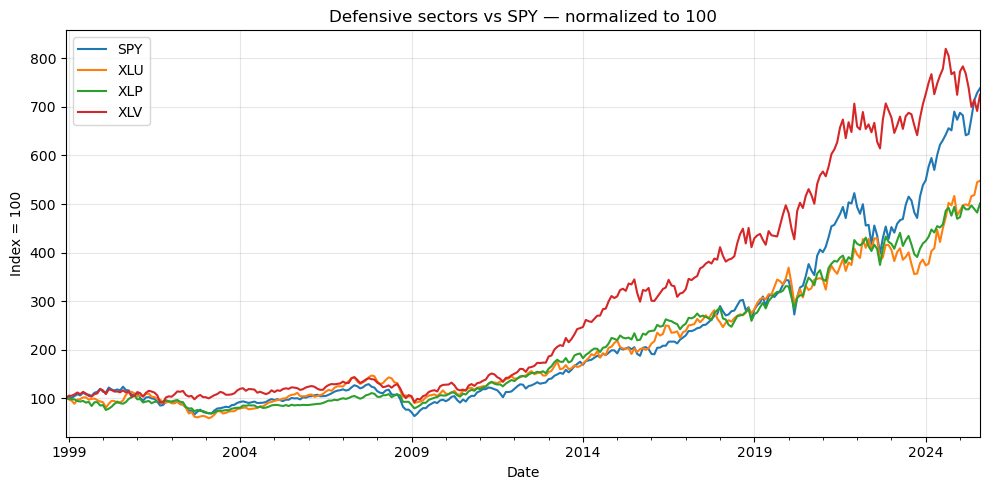

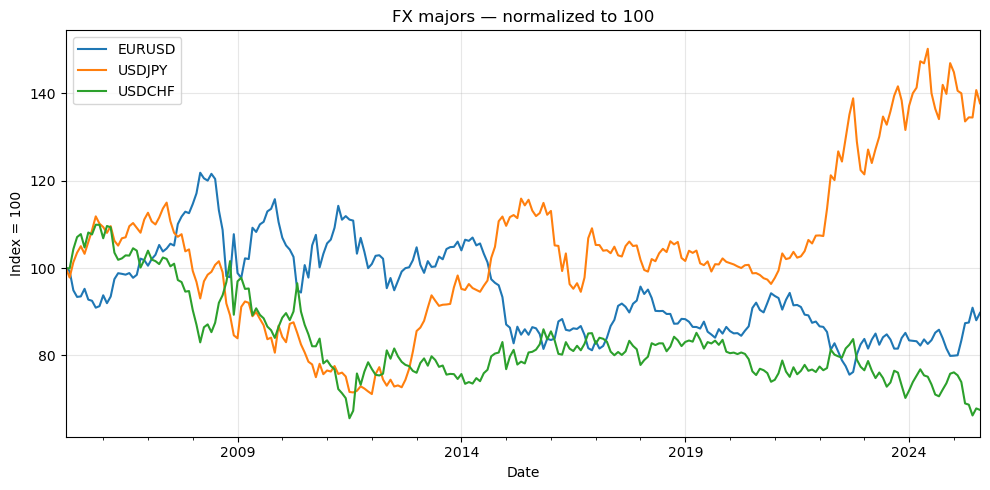

Done. ME Month-end resampling in place.


In [41]:
# --- IBKR EXTENSION (Gateway 4002) 
# pip install ib_insync nest_asyncio

import nest_asyncio, asyncio
nest_asyncio.apply()

from ib_insync import IB, Stock, Forex, util
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time

HOST = '127.0.0.1'    
PORT = 4002           
CLIENT_ID = 99        
USE_DELAYED = False   # set True if lack live market data subs

# -------- ensuring connection on 4002 --------
try:
    ib
except NameError:
    ib = IB()

if not getattr(ib, 'isConnected', lambda: False)():
    try: ib.disconnect()
    except: pass
    ib.connect(HOST, PORT, clientId=CLIENT_ID, timeout=8)
    print("Connected. Server time:", ib.reqCurrentTime())
else:
    print(f"Already connected to {ib.client.host}:{ib.client.port}")

if USE_DELAYED:
    ib.reqMarketDataType(4)  # 1=live, 3=delayed-frozen, 4=delayed
    print("Using delayed market data")

# -------- instruments --------
ETF_TICKERS = [
    "SPY","XLU","XLP","XLV","XLC","XLK","XLY","XLI","XLE","XLB","XLRE",
    "GLD","UUP","IEF","TLT"
]
FX_PAIRS = ["EURUSD","USDJPY","USDCHF"]

def etf(sym): return Stock(sym, 'SMART', 'USD', primaryExchange='ARCA')
def fx(pair): return Forex(pair)

etf_objs = [etf(s) for s in ETF_TICKERS]
fx_objs  = [fx(p)  for p in FX_PAIRS]

# -------- qualify robustly (batch + fallback) --------
def qualify_with_fallback(contracts, names, batch=6):
    ok = {}
    rem_idx = []
    for i in range(0, len(contracts), batch):
        chunk = contracts[i:i+batch]
        q = ib.qualifyContracts(*chunk)
        for nm, qc in zip(names[i:i+batch], q):
            if getattr(qc, 'conId', 0):
                ok[nm] = qc
            else:
                rem_idx.append((nm, names[i:i+batch].index(nm), chunk))
        time.sleep(0.25)

    # fallback via matching symbols
    if rem_idx:
        for nm, _, _chunk in rem_idx:
            try:
                ms = ib.reqMatchingSymbols(nm)
                pick = None
                for m in ms:
                    cd = m.contract
                    if cd.secType == 'STK' and cd.currency == 'USD':
                        pe = getattr(cd, 'primaryExchange', '') or ''
                        if pe in ('ARCA','NYSE','NASDAQ') or 'ARCA' in (m.marketName or ''):
                            pick = Stock(nm, 'SMART', 'USD', primaryExchange=pe or 'ARCA')
                            break
                if pick is not None:
                    q2 = ib.qualifyContracts(pick)
                    if q2 and getattr(q2[0], 'conId', 0):
                        ok[nm] = q2[0]
                        print(f"{nm}: resolved via matchingSymbols → {q2[0].primaryExchange}")
                    else:
                        print(f"{nm}: could not qualify after fallback")
                else:
                    print(f"{nm}: no suitable match from reqMatchingSymbols")
            except Exception as e:
                print(f"{nm}: matchingSymbols error → {e}")
            time.sleep(0.2)
    return ok

names_all = ETF_TICKERS + FX_PAIRS
qmap = qualify_with_fallback(etf_objs + fx_objs, names_all)
print(f"Resolved {len(qmap)}/{len(names_all)} contracts.")

# -------- historical bars helper (daily -> monthly) --------
def hist_df(name, con, duration='30 Y', bar='1 day'):
    what = 'MIDPOINT' if name in FX_PAIRS else 'ADJUSTED_LAST'
    bars = ib.reqHistoricalData(
        con, endDateTime='', durationStr=duration, barSizeSetting=bar,
        whatToShow=what, useRTH=False, formatDate=1, keepUpToDate=False
    )
    df = util.df(bars)
    if df.empty: return df
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).set_index('date').sort_index()
    if not df.index.is_unique:
        df = df[~df.index.duplicated(keep='last')]
    df.index.name = 'Date'
    return df[['close']].rename(columns={'close': name})

def fmt_dt(x):
    try: return pd.Timestamp(x).date()
    except Exception: return x

# -------- fetch all series --------
frames_daily = {}
for name, con in qmap.items():
    try:
        df = hist_df(name, con)
        if not df.empty:
            frames_daily[name] = df
            print(f"{name}: {fmt_dt(df.index.min())} → {fmt_dt(df.index.max())} ({len(df)} rows)")
        else:
            print(f"{name}: 0 rows (check market data permissions or set USE_DELAYED=True)")
    except Exception as e:
        print(f"{name}: fetch error → {e}")
    time.sleep(0.2)

# sanitize any duplicates (defensive)
for k, d in list(frames_daily.items()):
    if not isinstance(d.index, pd.DatetimeIndex):
        d.index = pd.to_datetime(d.index, errors='coerce')
        d = d.dropna().sort_index()
    if not d.index.is_unique:
        print(f"De-duplicating {k}: {d.index.duplicated().sum()} duplicate rows")
        d = d[~d.index.duplicated(keep='last')]
    frames_daily[k] = d.sort_index()

if not frames_daily:
    print("No IBKR data fetched."); raise SystemExit

# -------- daily panel -> month-end ('ME') --------
ib_daily = pd.concat(frames_daily.values(), axis=1, join='outer').sort_index()
ib_monthly = (ib_daily
              .resample('ME').last()
              .loc[~ib_daily.resample('ME').last().index.duplicated(keep='last')])
ib_monthly = ib_monthly.loc[:, ~ib_monthly.columns.duplicated(keep='last')]

# -------- merging into "combined_all_m" --------
# Ensuring base exists and is month-end indexed
if 'combined_all_m' in globals() and isinstance(combined_all_m, pd.DataFrame):
    base = combined_all_m.copy()
else:
    macro_m  = dfs["Macro"].set_index("Date").resample("ME").last()
    prices_m = dfs["Prices"].set_index("Date").resample("ME").last()
    yield_m  = dfs["Yield"].set_index("Date").resample("ME").last()
    base = macro_m.join(prices_m, how="outer").join(yield_m, how="outer")

base = (base.resample('ME').last()
            .loc[~base.resample('ME').last().index.duplicated(keep='last')])
base = base.loc[:, ~base.columns.duplicated(keep='last')]

# Handling overlapping columns 
MERGE_MODE = 'overwrite'  # {'overwrite','suffix','skip'}
overlap = ib_monthly.columns.intersection(base.columns)
if len(overlap) > 0:
    print("Overlapping columns:", list(overlap))
    if MERGE_MODE == 'overwrite':
        base = base.drop(columns=list(overlap))
        combined_all_m = base.join(ib_monthly, how='outer')
    elif MERGE_MODE == 'suffix':
        combined_all_m = base.join(ib_monthly.rename(columns={c: f"{c}_ibkr" for c in overlap}), how='outer')
    elif MERGE_MODE == 'skip':
        combined_all_m = base.join(ib_monthly.drop(columns=list(overlap)), how='outer')
    else:
        raise ValueError("MERGE_MODE must be one of {'overwrite','suffix','skip'}")
else:
    combined_all_m = base.join(ib_monthly, how='outer')

combined_all_m = combined_all_m.sort_index()
print("Merge complete. #rows, #cols:", combined_all_m.shape)
print("Sample IBKR cols:", [c for c in ["SPY","XLU","XLP","XLV","GLD","UUP","IEF","TLT","EURUSD","USDJPY","USDCHF"]
                           if c in combined_all_m.columns])

# -------- quick charts to check --------
def to_100(df):
    sub = df.dropna(how='any')
    return sub / sub.iloc[0] * 100 if not sub.empty else sub

have_def = [c for c in ["SPY","XLU","XLP","XLV"] if c in combined_all_m.columns]
if len(have_def) >= 2:
    to_100(combined_all_m[have_def]).plot(figsize=(10,5), title="Defensive sectors vs SPY — normalized to 100")
    plt.xlabel("Date"); plt.ylabel("Index = 100"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

fx_list = [c for c in FX_PAIRS if c in combined_all_m.columns]
if len(fx_list) >= 2:
    to_100(combined_all_m[fx_list]).plot(figsize=(10,5), title="FX majors — normalized to 100")
    plt.xlabel("Date"); plt.ylabel("Index = 100"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

print("Done. ME Month-end resampling in place.")


Connected. Server time: 2025-08-20 04:02:44+00:00
Resolved 18/18 contracts.
SPY: 1995-08-28 → 2025-08-19 (7542 rows)
XLU: 1998-12-22 → 2025-08-19 (6704 rows)
XLP: 1998-12-22 → 2025-08-19 (6704 rows)
XLV: 1998-12-22 → 2025-08-19 (6704 rows)
XLC: 2018-06-19 → 2025-08-19 (1802 rows)
XLK: 1998-12-22 → 2025-08-19 (6704 rows)
XLY: 1998-12-22 → 2025-08-19 (6704 rows)
XLI: 1998-12-22 → 2025-08-19 (6703 rows)
XLE: 1998-12-22 → 2025-08-19 (6704 rows)
XLB: 1998-12-22 → 2025-08-19 (6704 rows)
XLRE: 2015-10-08 → 2025-08-19 (2473 rows)
GLD: 2004-11-18 → 2025-08-19 (5218 rows)
UUP: 2007-02-20 → 2025-08-19 (4649 rows)
IEF: 2017-08-03 → 2025-08-19 (2022 rows)
TLT: 2016-02-03 → 2025-08-19 (2400 rows)
EURUSD: 2005-03-09 → 2025-08-20 (5304 rows)
USDJPY: 2005-03-09 → 2025-08-20 (5304 rows)
USDCHF: 2005-03-09 → 2025-08-20 (5304 rows)
Merge complete. #rows, #cols: (657, 24)
Sample IBKR cols: ['SPY', 'XLU', 'XLP', 'XLV', 'GLD', 'UUP', 'IEF', 'TLT', 'EURUSD', 'USDJPY', 'USDCHF']


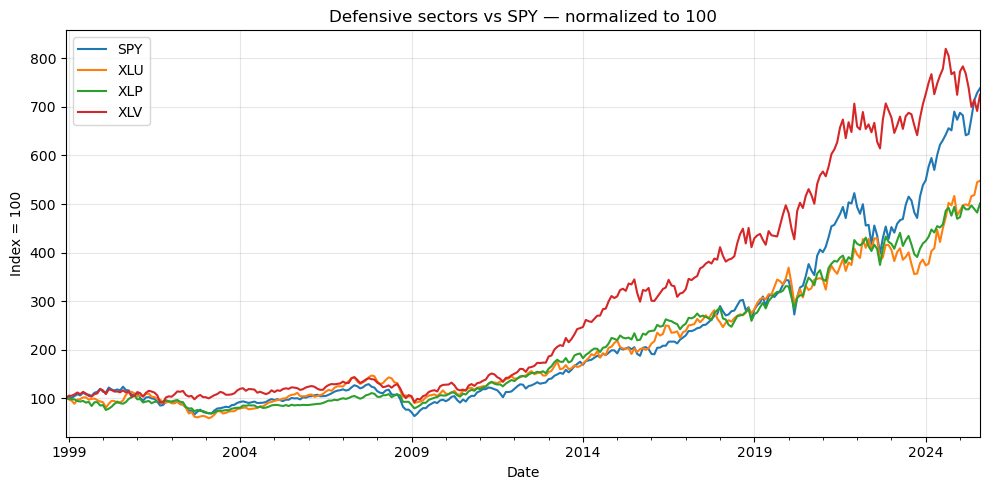

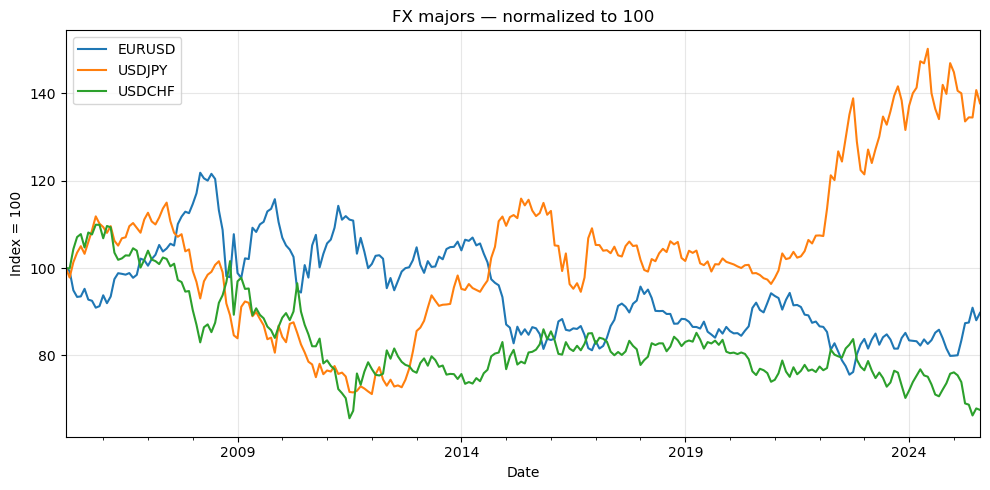

Done. ME Month-end resampling in place.


In [41]:
# --- IBKR EXTENSION (Gateway 4002) 
# pip install ib_insync nest_asyncio

import nest_asyncio, asyncio
nest_asyncio.apply()

from ib_insync import IB, Stock, Forex, util
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time

HOST = '127.0.0.1'    
PORT = 4002           
CLIENT_ID = 99        
USE_DELAYED = False   # set True if lack live market data subs

# -------- ensuring connection on 4002 --------
try:
    ib
except NameError:
    ib = IB()

if not getattr(ib, 'isConnected', lambda: False)():
    try: ib.disconnect()
    except: pass
    ib.connect(HOST, PORT, clientId=CLIENT_ID, timeout=8)
    print("Connected. Server time:", ib.reqCurrentTime())
else:
    print(f"Already connected to {ib.client.host}:{ib.client.port}")

if USE_DELAYED:
    ib.reqMarketDataType(4)  # 1=live, 3=delayed-frozen, 4=delayed
    print("Using delayed market data")

# -------- instruments --------
ETF_TICKERS = [
    "SPY","XLU","XLP","XLV","XLC","XLK","XLY","XLI","XLE","XLB","XLRE",
    "GLD","UUP","IEF","TLT"
]
FX_PAIRS = ["EURUSD","USDJPY","USDCHF"]

def etf(sym): return Stock(sym, 'SMART', 'USD', primaryExchange='ARCA')
def fx(pair): return Forex(pair)

etf_objs = [etf(s) for s in ETF_TICKERS]
fx_objs  = [fx(p)  for p in FX_PAIRS]

# -------- qualify robustly (batch + fallback) --------
def qualify_with_fallback(contracts, names, batch=6):
    ok = {}
    rem_idx = []
    for i in range(0, len(contracts), batch):
        chunk = contracts[i:i+batch]
        q = ib.qualifyContracts(*chunk)
        for nm, qc in zip(names[i:i+batch], q):
            if getattr(qc, 'conId', 0):
                ok[nm] = qc
            else:
                rem_idx.append((nm, names[i:i+batch].index(nm), chunk))
        time.sleep(0.25)

    # fallback via matching symbols
    if rem_idx:
        for nm, _, _chunk in rem_idx:
            try:
                ms = ib.reqMatchingSymbols(nm)
                pick = None
                for m in ms:
                    cd = m.contract
                    if cd.secType == 'STK' and cd.currency == 'USD':
                        pe = getattr(cd, 'primaryExchange', '') or ''
                        if pe in ('ARCA','NYSE','NASDAQ') or 'ARCA' in (m.marketName or ''):
                            pick = Stock(nm, 'SMART', 'USD', primaryExchange=pe or 'ARCA')
                            break
                if pick is not None:
                    q2 = ib.qualifyContracts(pick)
                    if q2 and getattr(q2[0], 'conId', 0):
                        ok[nm] = q2[0]
                        print(f"{nm}: resolved via matchingSymbols → {q2[0].primaryExchange}")
                    else:
                        print(f"{nm}: could not qualify after fallback")
                else:
                    print(f"{nm}: no suitable match from reqMatchingSymbols")
            except Exception as e:
                print(f"{nm}: matchingSymbols error → {e}")
            time.sleep(0.2)
    return ok

names_all = ETF_TICKERS + FX_PAIRS
qmap = qualify_with_fallback(etf_objs + fx_objs, names_all)
print(f"Resolved {len(qmap)}/{len(names_all)} contracts.")

# -------- historical bars helper (daily -> monthly) --------
def hist_df(name, con, duration='30 Y', bar='1 day'):
    what = 'MIDPOINT' if name in FX_PAIRS else 'ADJUSTED_LAST'
    bars = ib.reqHistoricalData(
        con, endDateTime='', durationStr=duration, barSizeSetting=bar,
        whatToShow=what, useRTH=False, formatDate=1, keepUpToDate=False
    )
    df = util.df(bars)
    if df.empty: return df
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).set_index('date').sort_index()
    if not df.index.is_unique:
        df = df[~df.index.duplicated(keep='last')]
    df.index.name = 'Date'
    return df[['close']].rename(columns={'close': name})

def fmt_dt(x):
    try: return pd.Timestamp(x).date()
    except Exception: return x

# -------- fetch all series --------
frames_daily = {}
for name, con in qmap.items():
    try:
        df = hist_df(name, con)
        if not df.empty:
            frames_daily[name] = df
            print(f"{name}: {fmt_dt(df.index.min())} → {fmt_dt(df.index.max())} ({len(df)} rows)")
        else:
            print(f"{name}: 0 rows (check market data permissions or set USE_DELAYED=True)")
    except Exception as e:
        print(f"{name}: fetch error → {e}")
    time.sleep(0.2)

# sanitize any duplicates (defensive)
for k, d in list(frames_daily.items()):
    if not isinstance(d.index, pd.DatetimeIndex):
        d.index = pd.to_datetime(d.index, errors='coerce')
        d = d.dropna().sort_index()
    if not d.index.is_unique:
        print(f"De-duplicating {k}: {d.index.duplicated().sum()} duplicate rows")
        d = d[~d.index.duplicated(keep='last')]
    frames_daily[k] = d.sort_index()

if not frames_daily:
    print("No IBKR data fetched."); raise SystemExit

# -------- daily panel -> month-end ('ME') --------
ib_daily = pd.concat(frames_daily.values(), axis=1, join='outer').sort_index()
ib_monthly = (ib_daily
              .resample('ME').last()
              .loc[~ib_daily.resample('ME').last().index.duplicated(keep='last')])
ib_monthly = ib_monthly.loc[:, ~ib_monthly.columns.duplicated(keep='last')]

# -------- merging into "combined_all_m" --------
# Ensuring base exists and is month-end indexed
if 'combined_all_m' in globals() and isinstance(combined_all_m, pd.DataFrame):
    base = combined_all_m.copy()
else:
    macro_m  = dfs["Macro"].set_index("Date").resample("ME").last()
    prices_m = dfs["Prices"].set_index("Date").resample("ME").last()
    yield_m  = dfs["Yield"].set_index("Date").resample("ME").last()
    base = macro_m.join(prices_m, how="outer").join(yield_m, how="outer")

base = (base.resample('ME').last()
            .loc[~base.resample('ME').last().index.duplicated(keep='last')])
base = base.loc[:, ~base.columns.duplicated(keep='last')]

# Handling overlapping columns 
MERGE_MODE = 'overwrite'  # {'overwrite','suffix','skip'}
overlap = ib_monthly.columns.intersection(base.columns)
if len(overlap) > 0:
    print("Overlapping columns:", list(overlap))
    if MERGE_MODE == 'overwrite':
        base = base.drop(columns=list(overlap))
        combined_all_m = base.join(ib_monthly, how='outer')
    elif MERGE_MODE == 'suffix':
        combined_all_m = base.join(ib_monthly.rename(columns={c: f"{c}_ibkr" for c in overlap}), how='outer')
    elif MERGE_MODE == 'skip':
        combined_all_m = base.join(ib_monthly.drop(columns=list(overlap)), how='outer')
    else:
        raise ValueError("MERGE_MODE must be one of {'overwrite','suffix','skip'}")
else:
    combined_all_m = base.join(ib_monthly, how='outer')

combined_all_m = combined_all_m.sort_index()
print("Merge complete. #rows, #cols:", combined_all_m.shape)
print("Sample IBKR cols:", [c for c in ["SPY","XLU","XLP","XLV","GLD","UUP","IEF","TLT","EURUSD","USDJPY","USDCHF"]
                           if c in combined_all_m.columns])

# -------- quick charts to check --------
def to_100(df):
    sub = df.dropna(how='any')
    return sub / sub.iloc[0] * 100 if not sub.empty else sub

have_def = [c for c in ["SPY","XLU","XLP","XLV"] if c in combined_all_m.columns]
if len(have_def) >= 2:
    to_100(combined_all_m[have_def]).plot(figsize=(10,5), title="Defensive sectors vs SPY — normalized to 100")
    plt.xlabel("Date"); plt.ylabel("Index = 100"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

fx_list = [c for c in FX_PAIRS if c in combined_all_m.columns]
if len(fx_list) >= 2:
    to_100(combined_all_m[fx_list]).plot(figsize=(10,5), title="FX majors — normalized to 100")
    plt.xlabel("Date"); plt.ylabel("Index = 100"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

print("Done. ME Month-end resampling in place.")


# Merging IBKR monthly into pipeline + visuals & analytics

Overlapping columns: ['SPY', 'XLU', 'XLP', 'XLV', 'XLC', 'XLK', 'XLY', 'XLI', 'XLE', 'XLB', 'XLRE', 'GLD', 'UUP', 'IEF', 'TLT', 'EURUSD', 'USDJPY', 'USDCHF']
Merged. Columns now include some IBKR series like: ['SPY', 'XLU', 'XLP', 'XLV', 'GLD', 'UUP', 'IEF', 'TLT', 'EURUSD', 'USDJPY', 'USDCHF']


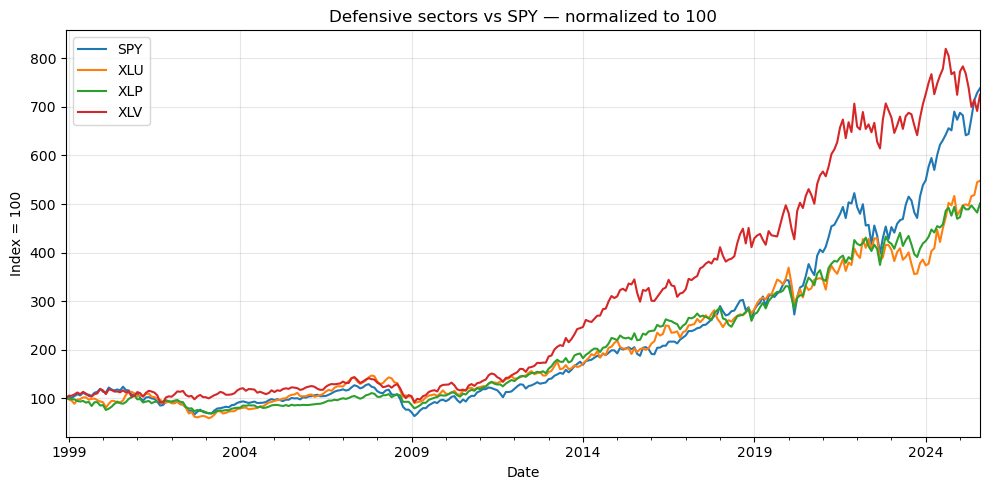

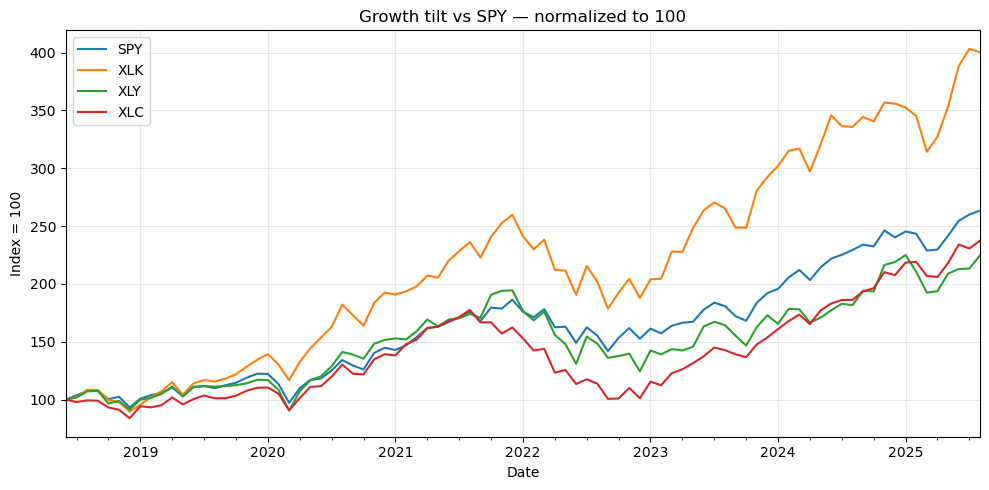

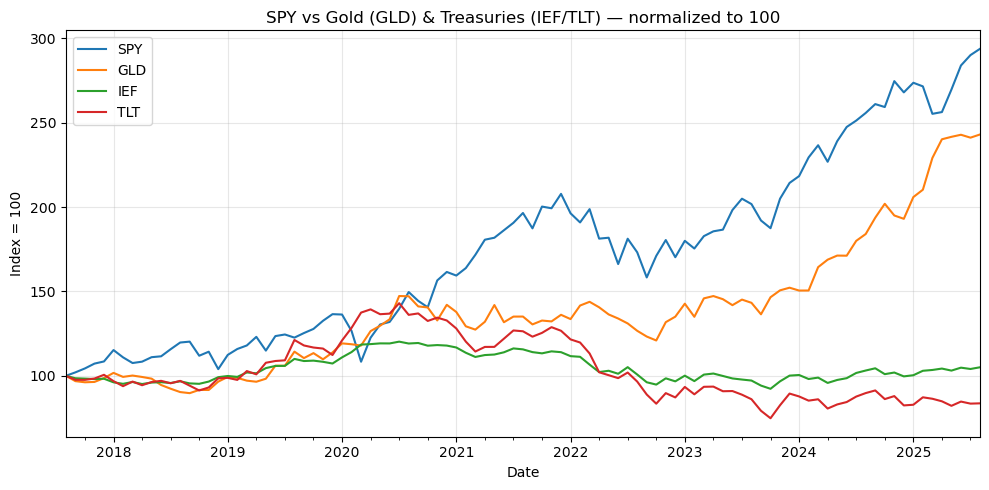

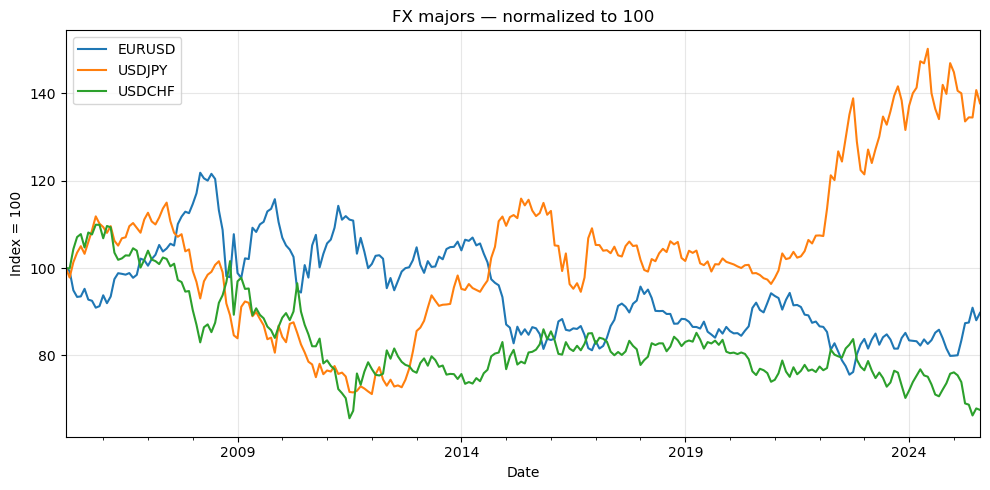

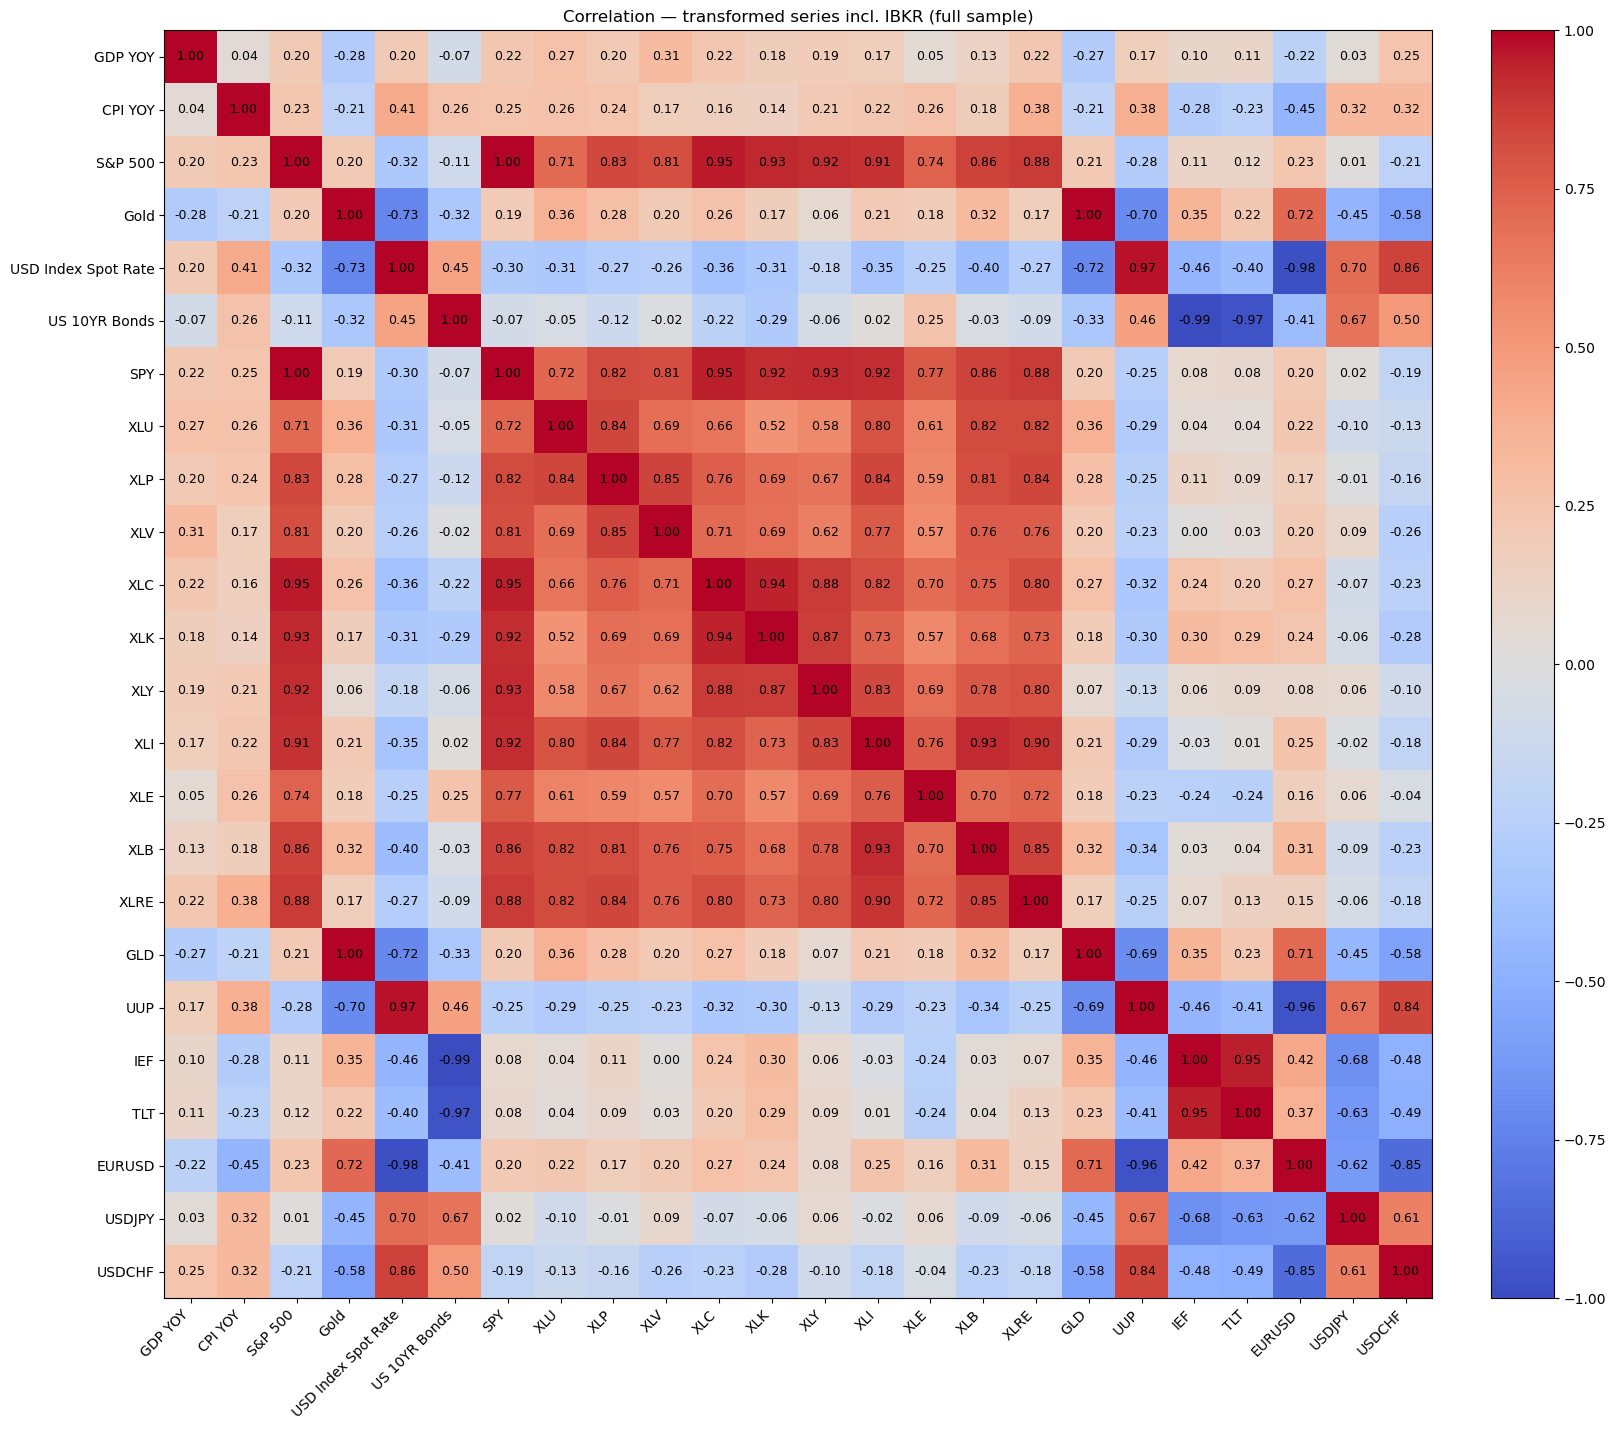

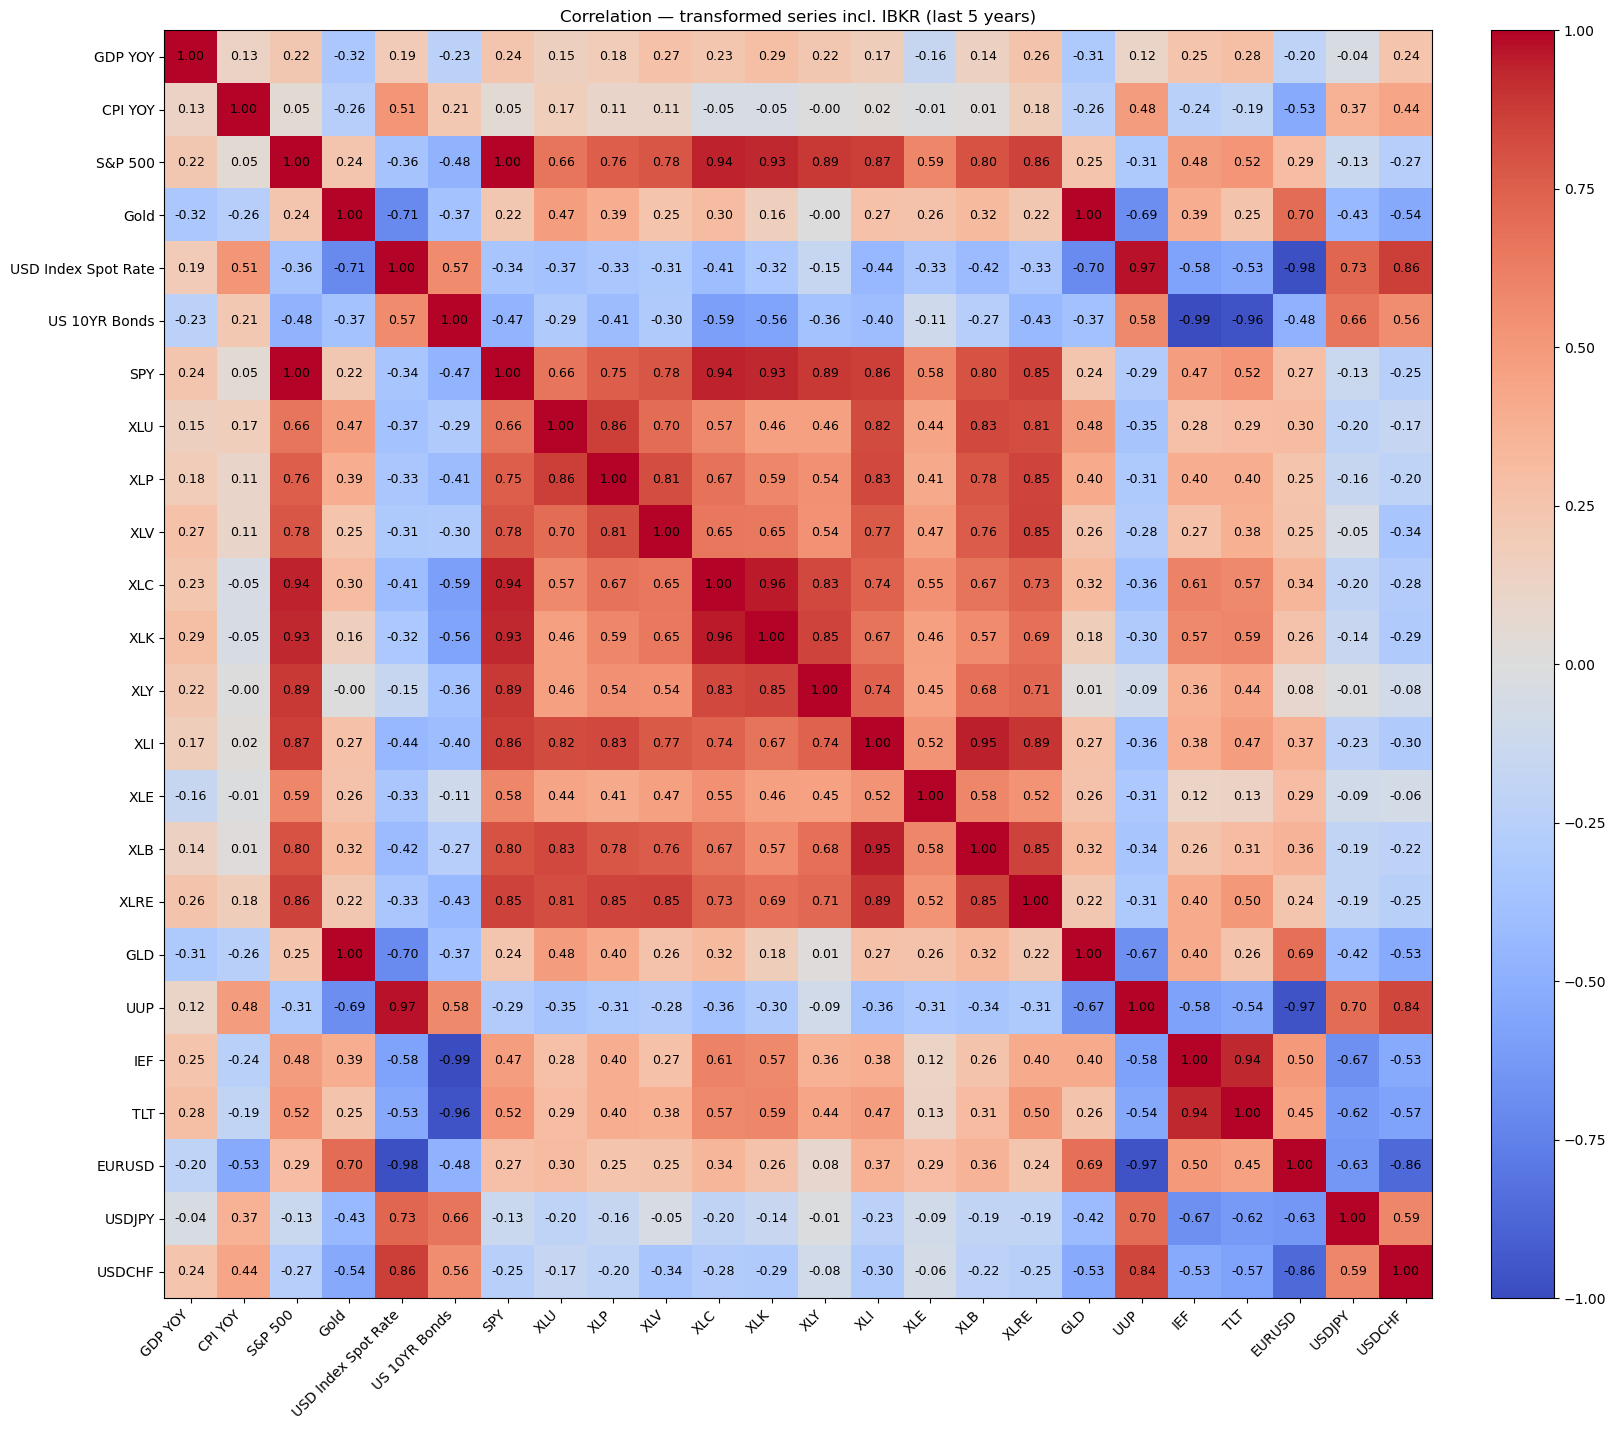

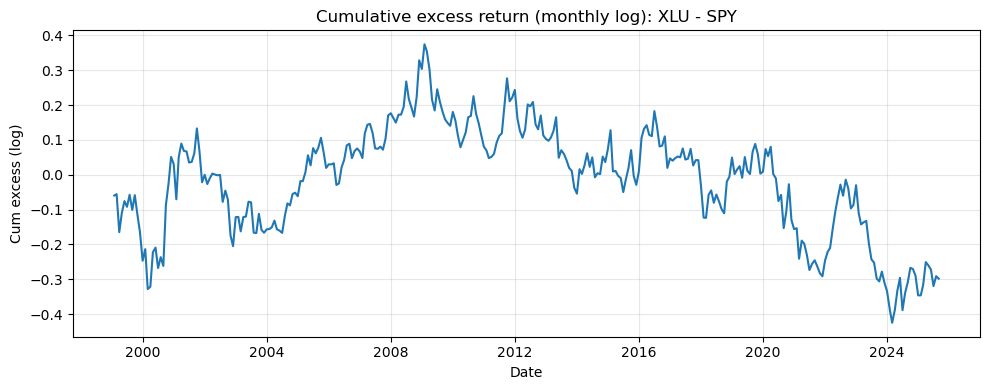

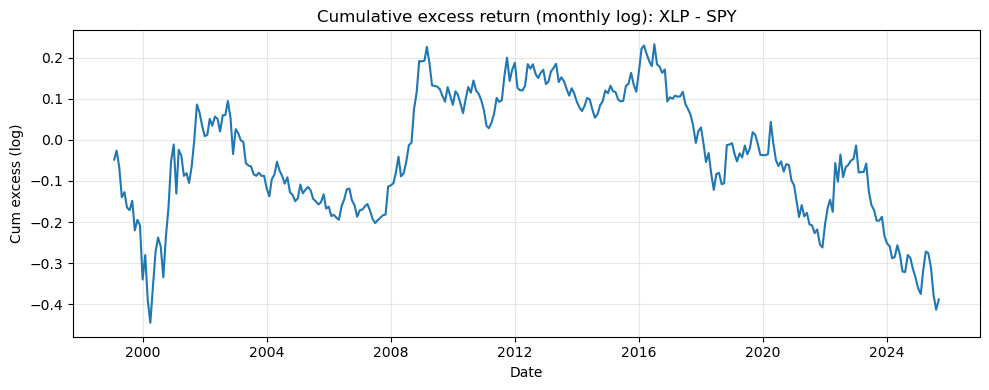

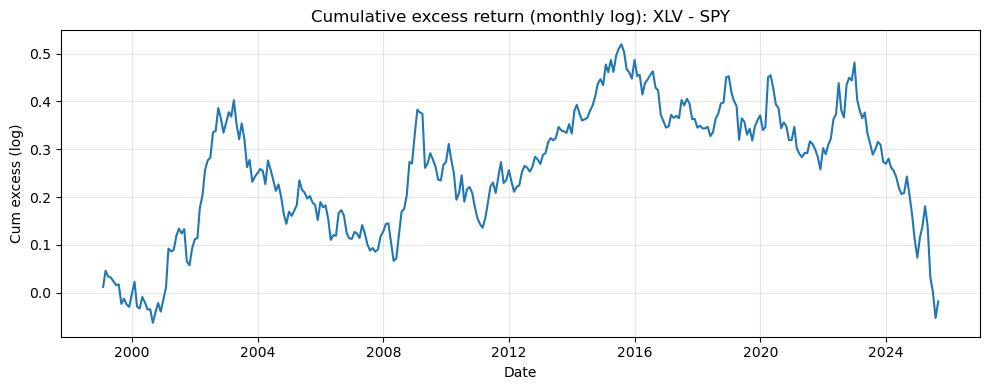

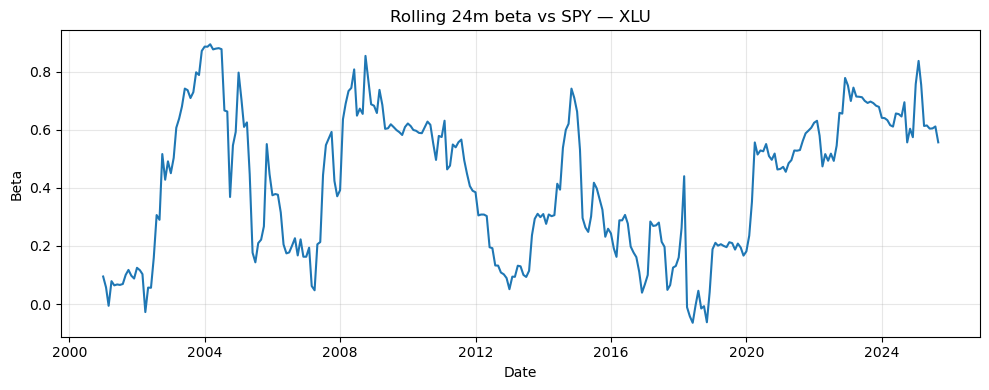

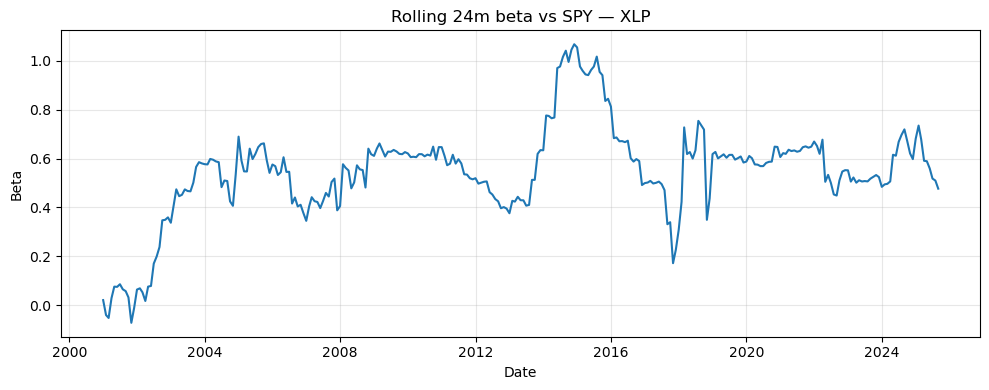

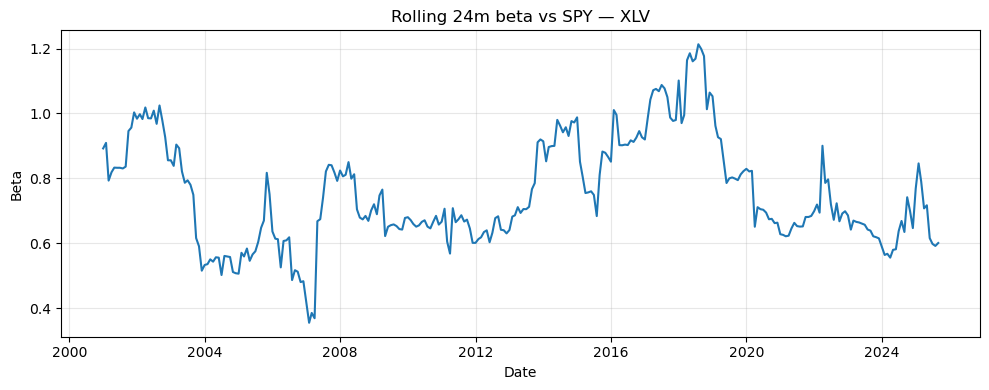

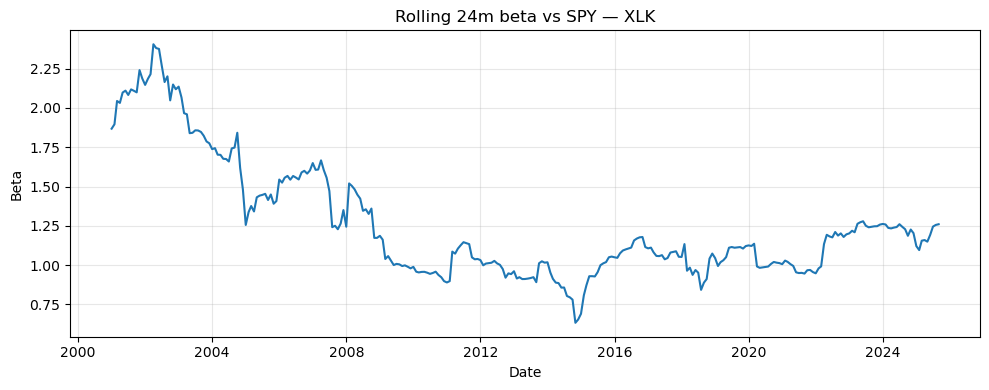

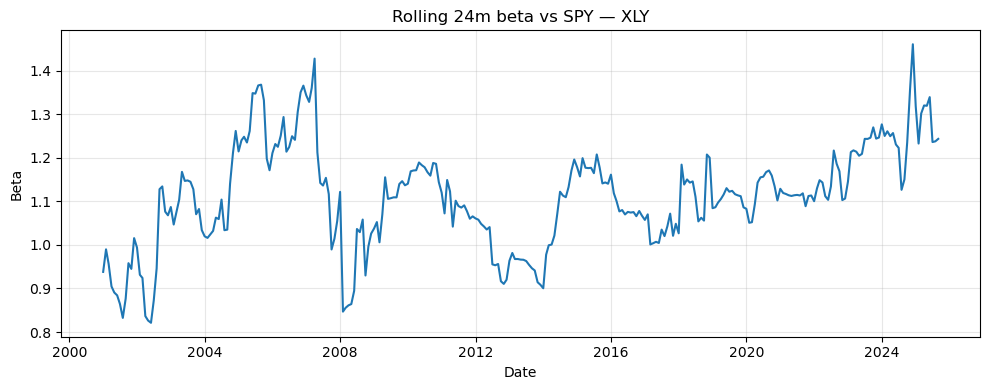

Done. Merging (month-end) complete.


In [44]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ---------- 0) Guard & month-end sanitize ----------
assert 'ib_monthly' in globals(), "ib_monthly not found — run the IBKR cell first."

# normalize to month-end and clean
def _to_me(df):
    df_me = (df.resample('ME').last()
               .loc[~df.resample('ME').last().index.duplicated(keep='last')])
    return df_me.loc[:, ~df_me.columns.duplicated(keep='last')]

ib_monthly = _to_me(ib_monthly)

# ---------- 1) Build/clean base combined_all_m ----------
if 'combined_all_m' in globals() and isinstance(combined_all_m, pd.DataFrame):
    base = _to_me(combined_all_m.copy())
else:
    # rebuild from your dfs if needed
    macro_m  = _to_me(dfs["Macro"].set_index("Date"))
    prices_m = _to_me(dfs["Prices"].set_index("Date"))
    yield_m  = _to_me(dfs["Yield"].set_index("Date"))
    base = macro_m.join(prices_m, how="outer").join(yield_m, how="outer")
    base = _to_me(base)

# ---------- 2) Safe merge (handles repeated runs) ----------
MERGE_MODE = 'overwrite'   # {'overwrite','suffix','skip'}

overlap = ib_monthly.columns.intersection(base.columns)
if len(overlap) > 0:
    print("Overlapping columns:", list(overlap))
    if MERGE_MODE == 'overwrite':
        base = base.drop(columns=list(overlap))
        combined_all_m = base.join(ib_monthly, how='outer')
    elif MERGE_MODE == 'suffix':
        ibm = ib_monthly.rename(columns={c: f"{c}_ibkr" for c in overlap})
        combined_all_m = base.join(ibm, how='outer')
    elif MERGE_MODE == 'skip':
        ibm = ib_monthly.drop(columns=list(overlap))
        combined_all_m = base.join(ibm, how='outer')
    else:
        raise ValueError("MERGE_MODE must be one of {'overwrite','suffix','skip'}")
else:
    combined_all_m = base.join(ib_monthly, how='outer')

combined_all_m = combined_all_m.sort_index()
print("Merged. Columns now include some IBKR series like:",
      [c for c in ["SPY","XLU","XLP","XLV","GLD","UUP","IEF","TLT","EURUSD","USDJPY","USDCHF"]
       if c in combined_all_m.columns])

# ---------- 3) Helpers ----------
if 'to_100' not in globals():
    def to_100(df):
        sub = df.dropna(how='any')
        return sub / sub.iloc[0] * 100 if not sub.empty else sub

if 'log_ret' not in globals():
    def log_ret(series):
        s = series.dropna()
        s = s[s > 0]
        return np.log(s).diff()

if 'first_diff' not in globals():
    def first_diff(s): return s.dropna().diff()

if 'heatmap' not in globals():
    def heatmap(corr: pd.DataFrame, title: str):
        if corr is None or corr.empty: return
        fig, ax = plt.subplots(figsize=(8 + 0.35*len(corr.columns), 6 + 0.35*len(corr.columns)))
        im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")
        ax.set_title(title)
        ax.set_xticks(range(len(corr.columns))); ax.set_yticks(range(len(corr.index)))
        ax.set_xticklabels(corr.columns, rotation=45, ha="right"); ax.set_yticklabels(corr.index)
        for i in range(corr.shape[0]):
            for j in range(corr.shape[1]):
                ax.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=9)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout(); plt.show()

# ---------- 4) Sanity overlays ----------
def _plot_norm(cols, title):
    have = [c for c in cols if c in combined_all_m.columns]
    if len(have) >= 2:
        to_100(combined_all_m[have]).plot(figsize=(10,5), title=title)
        plt.xlabel("Date"); plt.ylabel("Index = 100"); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

_plot_norm(["SPY","XLU","XLP","XLV"], "Defensive sectors vs SPY — normalized to 100")
_plot_norm(["SPY","XLK","XLY","XLC"], "Growth tilt vs SPY — normalized to 100")
_plot_norm(["SPY","GLD","IEF","TLT"], "SPY vs Gold (GLD) & Treasuries (IEF/TLT) — normalized to 100")
_plot_norm(["EURUSD","USDJPY","USDCHF"], "FX majors — normalized to 100")

# ---------- 5) Correlations (prices=log returns; YoY/yields=first diffs) ----------
tx_ib = {}
for c in combined_all_m.columns:
    name = str(c).lower()
    tx_ib[c] = first_diff(combined_all_m[c]) if ("yoy" in name or "yield" in name or "bond" in name) else log_ret(combined_all_m[c])
tx_ib = pd.DataFrame(tx_ib).dropna(how="all")

corr_full = tx_ib.dropna(how="any").corr()
heatmap(corr_full, "Correlation — transformed series incl. IBKR (full sample)")

if not tx_ib.empty and pd.notna(tx_ib.index.max()):
    cutoff = tx_ib.index.max() - pd.DateOffset(years=5)
    corr_recent = tx_ib.loc[tx_ib.index >= cutoff].dropna(how="any").corr()
    heatmap(corr_recent, "Correlation — transformed series incl. IBKR (last 5 years)")

# ---------- 6) Sector analytics ----------
ret_cols = [c for c in ["SPY","XLU","XLP","XLV","XLK","XLY"] if c in combined_all_m.columns]
rets = pd.DataFrame({c: log_ret(combined_all_m[c]) for c in ret_cols}).dropna(how='any')

# cumulative excess (defensives minus SPY)
for c in ["XLU","XLP","XLV"]:
    if c in rets.columns and "SPY" in rets.columns:
        ex = (rets[c] - rets["SPY"]).cumsum()
        if not ex.empty:
            plt.figure(figsize=(10,4))
            plt.plot(ex.index, ex.values)
            plt.title(f"Cumulative excess return (monthly log): {c} - SPY")
            plt.xlabel("Date"); plt.ylabel("Cum excess (log)"); plt.grid(True, alpha=0.3)
            plt.tight_layout(); plt.show()

def rolling_beta(df_returns, y_col, x_col="SPY", window=24):
    d = df_returns[[y_col, x_col]].dropna(how='any')
    if d.empty: return pd.Series(dtype=float)
    cov = d[y_col].rolling(window).cov(d[x_col])
    var = d[x_col].rolling(window).var()
    return cov / var

for c in ["XLU","XLP","XLV","XLK","XLY"]:
    if c in rets.columns and "SPY" in rets.columns:
        beta = rolling_beta(rets, c, "SPY", window=24)
        if not beta.empty:
            plt.figure(figsize=(10,4))
            plt.plot(beta.index, beta.values)
            plt.title(f"Rolling 24m beta vs SPY — {c}")
            plt.xlabel("Date"); plt.ylabel("Beta"); plt.grid(True, alpha=0.3)
            plt.tight_layout(); plt.show()

print("Done. Merging (month-end) complete.")


# Markov regime estimation (4‑state), transition matrix, and next‑month probabilities

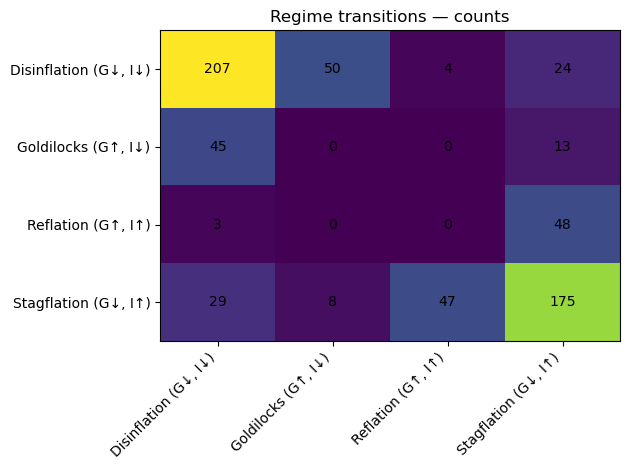

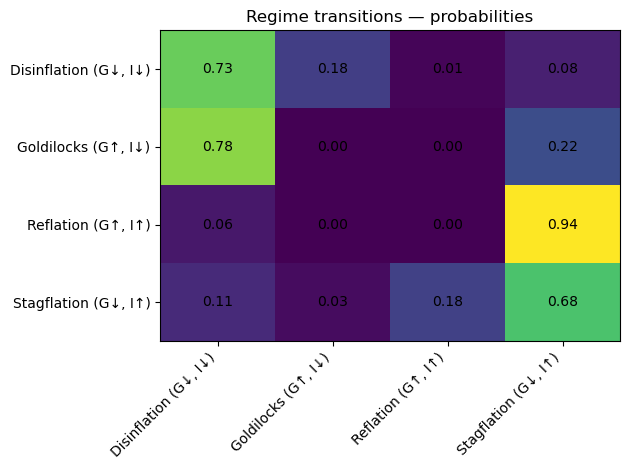

Current regime: Stagflation (G↓, I↑)
Next-month regime probabilities: {'Disinflation (G↓, I↓)': 0.11196911196911197, 'Goldilocks (G↑, I↓)': 0.03088803088803089, 'Reflation (G↑, I↑)': 0.18146718146718147, 'Stagflation (G↓, I↑)': 0.6756756756756757}


In [47]:
# Markov chain from 4-state regimes
import numpy as np
import pandas as pd

# Use your existing labelled regimes in `data["Regime"]`
r = data["Regime"].dropna().astype("category")
state_names = list(r.cat.categories)  # e.g. ['Disinflation','Goldilocks','Reflation','Stagflation']
S = len(state_names)
idx = {s:i for i,s in enumerate(state_names)}

# Transition counts & probabilities
mat = np.zeros((S,S), dtype=int)
for f,t in zip(r.iloc[:-1], r.iloc[1:]):
    mat[idx[f], idx[t]] += 1
row_sums = mat.sum(axis=1, keepdims=True)
P = mat / np.where(row_sums==0, 1, row_sums)

# Visualize
plt.figure(); plt.imshow(mat, aspect="auto", interpolation="nearest")
plt.xticks(range(S), state_names, rotation=45, ha="right")
plt.yticks(range(S), state_names)
for i in range(S):
    for j in range(S):
        plt.text(j,i,str(mat[i,j]), ha="center", va="center")
plt.title("Regime transitions — counts"); plt.tight_layout(); plt.show()

plt.figure(); plt.imshow(P, aspect="auto", interpolation="nearest")
plt.xticks(range(S), state_names, rotation=45, ha="right")
plt.yticks(range(S), state_names)
for i in range(S):
    for j in range(S):
        plt.text(j,i,f"{P[i,j]:.2f}", ha="center", va="center")
plt.title("Regime transitions — probabilities"); plt.tight_layout(); plt.show()

current_state = data["Regime"].dropna().iloc[-1]
print("Current regime:", current_state)
print("Next-month regime probabilities:", dict(zip(state_names, P[idx[current_state]])))


# Regime‑conditional moments for (S&P, Gold, UST)

In [50]:
assets = ["SPX_ret","Gold_ret","UST_ret"]
df_rg = data[assets].dropna()
moments = {}
for s in state_names:
    sub = df_rg.loc[data["Regime"]==s]
    if len(sub) < 12:
        continue
    mu = sub.mean().values               # [muS, muG, muU]
    Sigma = sub.cov().values             # 3x3
    moments[s] = (mu, Sigma)

assert len(moments)>=2, "Not enough data per regime to estimate moments."

# Markov‑weighted hedge

### Optimization: choose w and γ to minimize expected hedged variance

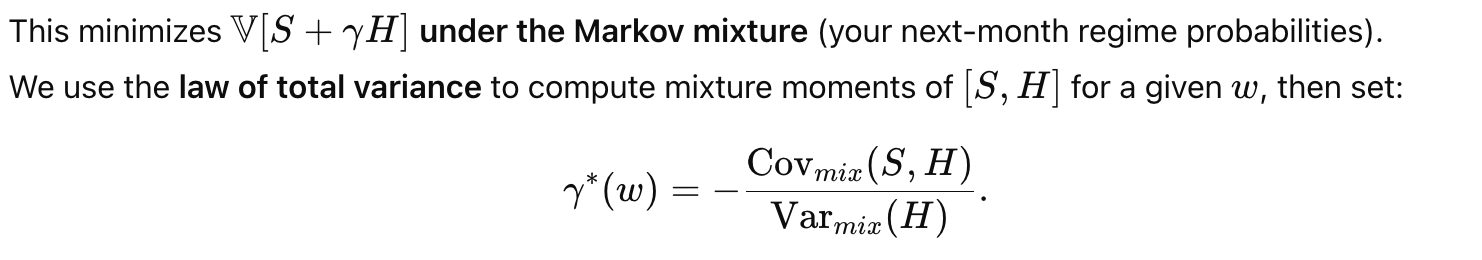

Markov hedge (1M horizon): w_gold=0.00, gamma=-0.16, exp var=0.001907


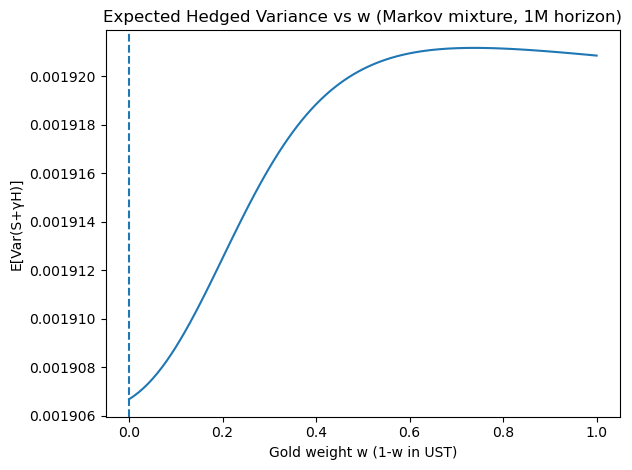

In [55]:
def mixture_SH_moments(moments, state_names, p_vec, w):
    """
    Build mixture mean/cov for [S, H(w)] where H = w*Gold + (1-w)*UST.
    Uses law of total variance across regimes with weights p_vec.
    """
    # First pass: collect regime-specific mu_SH and Sigma_SH
    mu_list, Sigma_list = [], []
    for s in state_names:
        mu3, S3 = moments[s]             # mu3=[muS,muG,muU], S3 is 3x3
        muS, muG, muU = mu3
        varS, varG, varU = S3[0,0], S3[1,1], S3[2,2]
        covSG, covSU, covGU = S3[0,1], S3[0,2], S3[1,2]
        muH  = w*muG + (1-w)*muU
        varH = w*w*varG + (1-w)*(1-w)*varU + 2*w*(1-w)*covGU
        covSH = w*covSG + (1-w)*covSU
        mu_list.append(np.array([muS, muH]))
        Sigma_list.append(np.array([[varS, covSH],[covSH, varH]]))

    # Mixture mean
    mu_mix = sum(p_vec[i]*mu_list[i] for i in range(len(state_names)))
    # Mixture covariance = sum p*(Sigma_r + (mu_r - mu_mix)(mu_r - mu_mix)')
    Sigma_mix = np.zeros((2,2))
    for i in range(len(state_names)):
        diff = (mu_list[i] - mu_mix).reshape(2,1)
        Sigma_mix += p_vec[i]*(Sigma_list[i] + diff@diff.T)
    return mu_mix, Sigma_mix

def opt_markov_hedge(moments, state_names, P, current_state, horizon=1, grid=101):
    """Return (best_w, best_gamma, min_variance, scan_records) for Markov mixture at given horizon."""
    i = state_names.index(current_state)
    P_h = np.linalg.matrix_power(P, horizon)
    p_vec = P_h[i]                       # next-horizon regime probabilities
    ws = np.linspace(0,1,grid)
    best = None
    records = []
    for w in ws:
        _, Sigma_mix = mixture_SH_moments(moments, state_names, p_vec, w)
        varS, varH, covSH = Sigma_mix[0,0], Sigma_mix[1,1], Sigma_mix[0,1]
        if varH <= 1e-12:
            gamma = 0.0
            var_hedged = varS
        else:
            gamma = - covSH / varH
            var_hedged = varS + 2*gamma*covSH + (gamma**2)*varH
        records.append((w, gamma, var_hedged))
        if (best is None) or (var_hedged < best[2]):
            best = (w, gamma, var_hedged)

    return best, records

best_1m, recs_1m = opt_markov_hedge(moments, state_names, P, current_state, horizon=1, grid=101)
print("Markov hedge (1M horizon): w_gold=%.2f, gamma=%.2f, exp var=%.6f" % best_1m)

# Plot expected hedged variance vs w
ws = [r[0] for r in recs_1m]; varM = [r[2] for r in recs_1m]
plt.figure(); plt.plot(ws, varM); 
plt.axvline(best_1m[0], linestyle="--")
plt.title("Expected Hedged Variance vs w (Markov mixture, 1M horizon)")
plt.xlabel("Gold weight w (1-w in UST)"); plt.ylabel("E[Var(S+γH)]")
plt.tight_layout(); plt.show()


# Markov‑weighted Markowitz MVO (long-only, weight caps)

### This computes the mixture mean and covariance of [S&P, Gold, UST] under the next‑period Markov probabilities, then solves a capped long‑only mean‑variance portfolio.

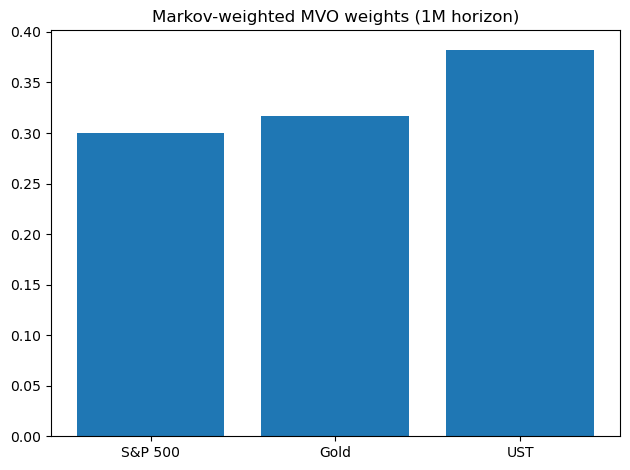

{'S&P 500': 0.3, 'Gold': 0.317, 'UST': 0.382}


In [59]:
def markov_mvo(moments, state_names, P, current_state, horizon=1, lam=5.0, cap=0.8):
    i = state_names.index(current_state)
    P_h = np.linalg.matrix_power(P, horizon)
    p_vec = P_h[i]

    # Mixture mean/cov in 3-asset space
    mu_mix = np.zeros(3); Sigma_mix = np.zeros((3,3))
    mus = []
    for k,s in enumerate(state_names):
        mu, Sigma = moments[s]
        mus.append(mu)
        mu_mix += p_vec[k]*mu
    for k,s in enumerate(state_names):
        mu, Sigma = moments[s]
        diff = (mu - mu_mix).reshape(3,1)
        Sigma_mix += p_vec[k]*(Sigma + diff@diff.T)

    # Projected gradient ascent on mu'w - lam * w'Σw, sum w=1, 0<=w<=cap
    n=3; w=np.ones(n)/n; best_w=w.copy(); best_val=-1e18
    for _ in range(2000):
        grad = mu_mix - 2*lam*(Sigma_mix @ w)
        w = w + 0.01*grad
        w = np.clip(w, 0, cap)
        w = w/w.sum() if w.sum()>0 else np.ones(n)/n
        val = mu_mix@w - lam*(w@Sigma_mix@w)
        if val>best_val: best_val=val; best_w=w.copy()
    return best_w, mu_mix, Sigma_mix

w_star, mu_mix3, Sigma_mix3 = markov_mvo(moments, state_names, P, current_state, horizon=1, lam=5.0, cap=0.8)
labels3 = ["S&P 500","Gold","UST"]
plt.figure(); plt.bar(labels3, w_star); plt.title("Markov-weighted MVO weights (1M horizon)")
plt.tight_layout(); plt.show()
print(dict(zip(labels3, np.round(w_star,3))))


# 3D Markov surface: 
# 𝑤–𝛾∗(𝑤)–Expected Variance

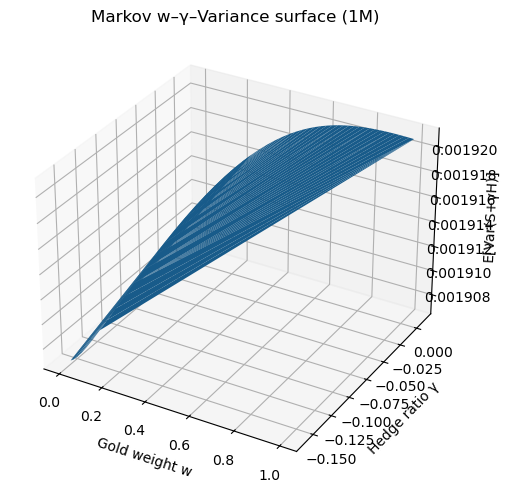

In [62]:
from mpl_toolkits.mplot3d import Axes3D 

best_1m, recs_1m = opt_markov_hedge(moments, state_names, P, current_state, horizon=1, grid=51)
W = np.array([r[0] for r in recs_1m])
G = np.array([r[1] for r in recs_1m])
V = np.array([r[2] for r in recs_1m])

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(W, G, V)
ax.set_xlabel("Gold weight w"); ax.set_ylabel("Hedge ratio γ"); ax.set_zlabel("E[Var(S+γH)]")
plt.title("Markov w–γ–Variance surface (1M)")
plt.tight_layout(); plt.show()


# Markov Hedge Panel (expected hedged variance vs w)

### Build transition matrix P 

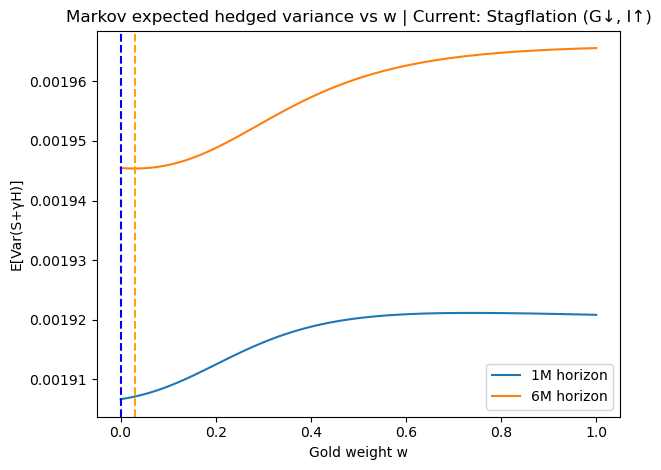

Markov hedge optimal (1M): w_gold=0.00, γ=-0.16
Markov hedge optimal (6M): w_gold=0.03, γ=-0.18


In [66]:
    r = data["Regime"].dropna().astype("category")
    state_names = list(r.cat.categories)
    idx = {s:i for i,s in enumerate(state_names)}
    S = len(state_names)

    mat = np.zeros((S,S), dtype=int)
    for f,t in zip(r.iloc[:-1], r.iloc[1:]):
        mat[idx[f], idx[t]] += 1
    row_sums = mat.sum(axis=1, keepdims=True)
    P = mat / np.where(row_sums==0, 1, row_sums)

    # regime-conditioned moments
    assets = ["SPX_ret","Gold_ret","UST_ret"]
    df_rg = data[assets].dropna()
    moments = {}
    for s in state_names:
        sub = df_rg.loc[data["Regime"]==s]
        if len(sub) >= 12:
            moments[s] = (sub.mean().values, sub.cov().values)

    # mixture SH moments
    def mixture_SH_moments(moments, state_names, p_vec, w):
        mu_list, Sigma_list = [], []
        for s in state_names:
            mu3, S3 = moments[s]
            muS, muG, muU = mu3
            varS, varG, varU = S3[0,0], S3[1,1], S3[2,2]
            covSG, covSU, covGU = S3[0,1], S3[0,2], S3[1,2]
            muH  = w*muG + (1-w)*muU
            varH = w*w*varG + (1-w)*(1-w)*varU + 2*w*(1-w)*covGU
            covSH = w*covSG + (1-w)*covSU
            mu_list.append(np.array([muS, muH]))
            Sigma_list.append(np.array([[varS, covSH],[covSH, varH]]))
        mu_mix = sum(p_vec[i]*mu_list[i] for i in range(len(state_names)))
        Sigma_mix = np.zeros((2,2))
        for i in range(len(state_names)):
            diff = (mu_list[i] - mu_mix).reshape(2,1)
            Sigma_mix += p_vec[i]*(Sigma_list[i] + diff@diff.T)
        return mu_mix, Sigma_mix

    def opt_markov_hedge(moments, state_names, P, current_state, horizon=1, grid=101):
        i = state_names.index(current_state)
        P_h = np.linalg.matrix_power(P, horizon)
        p_vec = P_h[i]
        ws = np.linspace(0,1,grid)
        records = []
        best = None
        for w in ws:
            _, Sigma_mix = mixture_SH_moments(moments, state_names, p_vec, w)
            varS, varH, covSH = Sigma_mix[0,0], Sigma_mix[1,1], Sigma_mix[0,1]
            if varH <= 1e-12:
                gamma, varHedged = 0.0, varS
            else:
                gamma = -covSH/varH
                varHedged = varS + 2*gamma*covSH + gamma**2*varH
            records.append((w,gamma,varHedged))
            if best is None or varHedged < best[2]:
                best = (w,gamma,varHedged)
        return best, records

    current_state = data["Regime"].dropna().iloc[-1]
    best1, recs1 = opt_markov_hedge(moments, state_names, P, current_state, horizon=1)
    best6, recs6 = opt_markov_hedge(moments, state_names, P, current_state, horizon=6)

    ws = [r[0] for r in recs1]
    var1 = [r[2] for r in recs1]
    var6 = [r[2] for r in recs6]

    plt.figure()
    plt.plot(ws, var1, label="1M horizon")
    plt.plot(ws, var6, label="6M horizon")
    plt.axvline(best1[0], linestyle="--", color="blue")
    plt.axvline(best6[0], linestyle="--", color="orange")
    plt.title(f"Markov expected hedged variance vs w | Current: {current_state}")
    plt.xlabel("Gold weight w"); plt.ylabel("E[Var(S+γH)]")
    plt.legend(); plt.tight_layout(); plt.show()

    print(f"Markov hedge optimal (1M): w_gold={best1[0]:.2f}, γ={best1[1]:.2f}")
    print(f"Markov hedge optimal (6M): w_gold={best6[0]:.2f}, γ={best6[1]:.2f}")


### Regime Transition Matrix — Counts & Probabilities (1M and 6M)

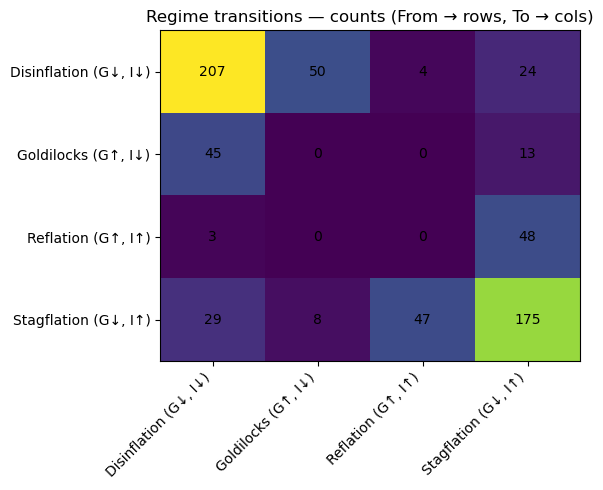

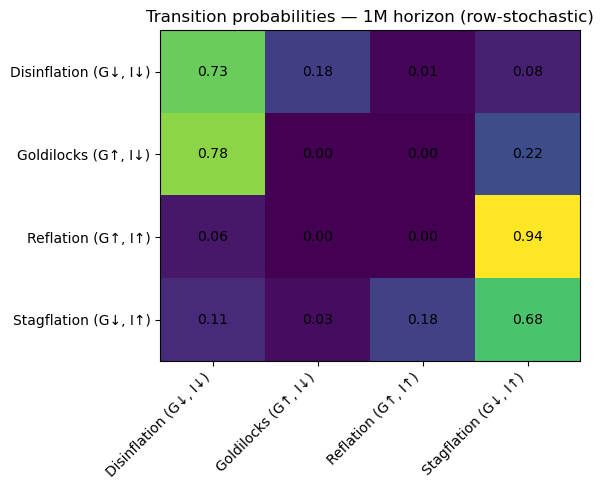

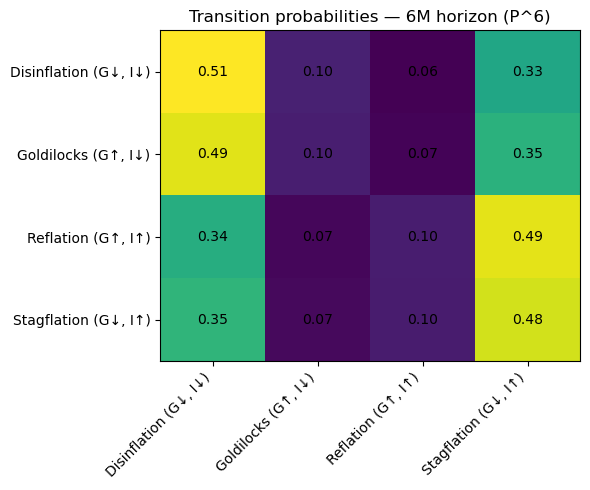

Current regime: Stagflation (G↓, I↑)
Next-month regime probabilities: {'Disinflation (G↓, I↓)': 0.112, 'Goldilocks (G↑, I↓)': 0.031, 'Reflation (G↑, I↑)': 0.181, 'Stagflation (G↓, I↑)': 0.676}
6-month regime probabilities:   {'Disinflation (G↓, I↓)': 0.354, 'Goldilocks (G↑, I↓)': 0.073, 'Reflation (G↑, I↑)': 0.096, 'Stagflation (G↓, I↑)': 0.478}


In [69]:
    r = data["Regime"].dropna().astype("category")
    state_names = list(r.cat.categories)
    S = len(state_names)
    idx = {s:i for i,s in enumerate(state_names)}

    # Build transition counts
    mat = np.zeros((S, S), dtype=int)
    for f, t in zip(r.iloc[:-1], r.iloc[1:]):
        mat[idx[f], idx[t]] += 1

    # Row-normalized probabilities (next month)
    row_sums = mat.sum(axis=1, keepdims=True)
    P = mat / np.where(row_sums == 0, 1, row_sums)

    # 6-month transition (P^6)
    P6 = np.linalg.matrix_power(P, 6)

    # --- Heatmap: counts ---
    plt.figure(figsize=(6,5))
    plt.imshow(mat, aspect="auto", interpolation="nearest")
    plt.xticks(range(S), state_names, rotation=45, ha="right")
    plt.yticks(range(S), state_names)
    for i in range(S):
        for j in range(S):
            plt.text(j, i, str(mat[i, j]), ha="center", va="center")
    plt.title("Regime transitions — counts (From → rows, To → cols)")
    plt.tight_layout(); plt.show()

    # --- Heatmap: next-month probabilities ---
    plt.figure(figsize=(6,5))
    plt.imshow(P, aspect="auto", interpolation="nearest")
    plt.xticks(range(S), state_names, rotation=45, ha="right")
    plt.yticks(range(S), state_names)
    for i in range(S):
        for j in range(S):
            plt.text(j, i, f"{P[i, j]:.2f}", ha="center", va="center")
    plt.title("Transition probabilities — 1M horizon (row-stochastic)")
    plt.tight_layout(); plt.show()

    # --- Heatmap: 6-month probabilities (P^6) ---
    plt.figure(figsize=(6,5))
    plt.imshow(P6, aspect="auto", interpolation="nearest")
    plt.xticks(range(S), state_names, rotation=45, ha="right")
    plt.yticks(range(S), state_names)
    for i in range(S):
        for j in range(S):
            plt.text(j, i, f"{P6[i, j]:.2f}", ha="center", va="center")
    plt.title("Transition probabilities — 6M horizon (P^6)")
    plt.tight_layout(); plt.show()

    # Current regime & rotation odds
    current_state = data["Regime"].dropna().iloc[-1]
    i_cur = idx[current_state]
    next_probs_1m = {s: round(float(P[i_cur, idx[s]]), 3) for s in state_names}
    next_probs_6m = {s: round(float(P6[i_cur, idx[s]]), 3) for s in state_names}
    print(f"Current regime: {current_state}")
    print("Next-month regime probabilities:", next_probs_1m)
    print("6-month regime probabilities:  ", next_probs_6m)


# Current-regime rotation odds — bar charts for P (1M) and P^6 (6M)

### Rebuild r, states, P 

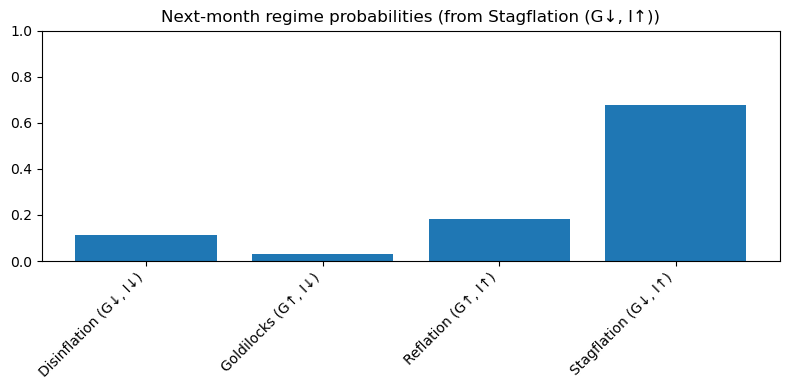

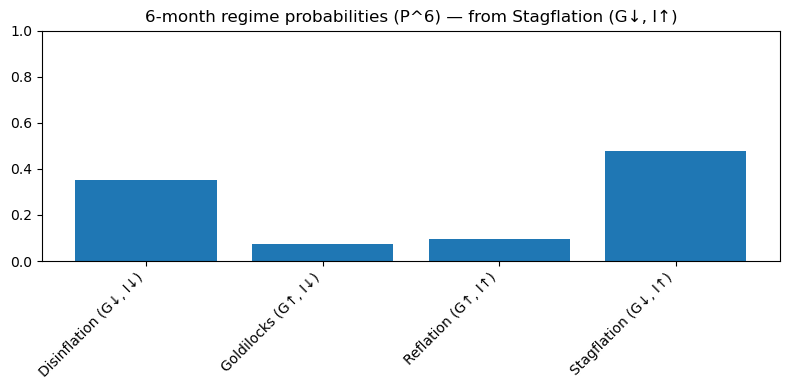

Current regime: Stagflation (G↓, I↑)
Next-month probs: {'Disinflation (G↓, I↓)': 0.112, 'Goldilocks (G↑, I↓)': 0.031, 'Reflation (G↑, I↑)': 0.181, 'Stagflation (G↓, I↑)': 0.676}
6-month probs:   {'Disinflation (G↓, I↓)': 0.354, 'Goldilocks (G↑, I↓)': 0.073, 'Reflation (G↑, I↑)': 0.096, 'Stagflation (G↓, I↑)': 0.478}


In [73]:
    r = data["Regime"].dropna().astype("category")
    state_names = list(r.cat.categories)
    S = len(state_names)
    idx = {s:i for i,s in enumerate(state_names)}

    # Transition counts and probabilities
    mat = np.zeros((S, S), dtype=int)
    for f, t in zip(r.iloc[:-1], r.iloc[1:]):
        mat[idx[f], idx[t]] += 1
    row_sums = mat.sum(axis=1, keepdims=True)
    P = mat / np.where(row_sums == 0, 1, row_sums)
    P6 = np.linalg.matrix_power(P, 6)

    # Current regime row
    current_state = data["Regime"].dropna().iloc[-1]
    i_cur = idx[current_state]
    p1 = P[i_cur, :]
    p6 = P6[i_cur, :]

    # Bar chart: next-month probabilities from current regime
    plt.figure(figsize=(8,4))
    plt.bar(range(S), p1)
    plt.xticks(range(S), state_names, rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.title(f"Next-month regime probabilities (from {current_state})")
    plt.tight_layout()
    plt.show()

    # Bar chart: 6-month probabilities from current regime
    plt.figure(figsize=(8,4))
    plt.bar(range(S), p6)
    plt.xticks(range(S), state_names, rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.title(f"6-month regime probabilities (P^6) — from {current_state}")
    plt.tight_layout()
    plt.show()

    # Quick printout (handy in console/logs)
    print("Current regime:", current_state)
    print("Next-month probs:", {s: round(float(p1[idx[s]]), 3) for s in state_names})
    print("6-month probs:  ", {s: round(float(p6[idx[s]]), 3) for s in state_names})


# Hedging recipe by economic regime

### (Current regime: Growth trend from GDP YoY vs 24‑m avg, Inflation trend from CPI YoY vs 12‑m avg.)

### Goldilocks (Growth↑, Inflation↓)

Goal: Light, carry‑friendly hedge.

Hedge mix: UST‑heavy (e.g., Gold 0–25%, UST 75–100%).

Why: Equities usually do well; bonds aren’t fighting inflation and can diversify; gold is less crucial.

γ (overlay) tendency: Often small in magnitude; sign can be negative if SPX–UST turns mildly positive in strong expansions (your w–γ plot shows this). Treat negative γ as “keep the hedge light / neutral” rather than forcing a short.

### Reflation (Growth↑, Inflation↑)

Goal: Hedge the inflation shock without fighting growth.

Hedge mix: Gold‑heavy (e.g., Gold 60–90%, UST 10–40%).

Why: Reflation often lifts yields (a headwind for Treasuries) while gold benefits from inflation / falling real rates.

γ tendency: Modest positive or near‑zero; avoid large UST overlays when the curve is bear‑steepening.


### Disinflation / Slowdown (Growth↓, Inflation↓)

Goal: Hedge recession risk and equity drawdowns.

Hedge mix: UST‑heavy (e.g., Gold 10–40%, UST 60–90%).

Why: When growth rolls over, USTs rally on duration; gold is a secondary diversifier.

γ tendency: More positive (SPX–UST tends to be negatively correlated in risk‑off). Size gamma to your variance/CVaR goal.

### Stagflation (Growth↓, Inflation↑)

Goal: Hedge inflation + weak growth simultaneously.

Hedge mix: Gold‑tilt but keep some duration optional (e.g., Gold 50–80%, UST 20–50%).

Why: Treasuries can struggle when inflation stays sticky; gold is the pure inflation hedge. Keep some UST for left‑tail “growth shock” rallies.

γ tendency: Typically positive if the combined basket H is negatively correlated with SPX; size via your w–γ heat/surface.

### Use these ranges as policy bands; 
The Variance‑Reduction heatmap and w–γ surface tell you where inside the band you should be today.

# Picking the hedge today using my dashboard

### Identify the regime

Look at the regime label in your data panel (CPI YoY vs its 12‑m mean; GDP YoY vs its 24‑m mean).
Cross‑check with yield‑curve (2s10s, 3m10y) and jobs (NFP change, UNRATE) to sanity‑check the macro story.

### Set the mix 𝑤 (Gold weight in H = w·Gold + (1–w)·UST)

### Variance‑Reduction vs w heatmap: 
choose the brightest spot in the row for your current regime → that’s your target w.

Then glance at the w–γ–Variance 3D surface for your regime: confirms the required γ at that w and how sensitive variance is around it.

### Size the overlay 𝛾

Use the formula implemented: 

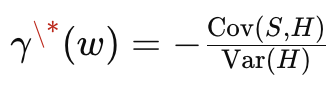

Interpret the sign:

If Corr(SPX, H) < 0 ⇒ γ is positive (go long the hedge basket).

If Corr(SPX, H) > 0 ⇒ γ is negative (keep it small; or prefer allocational hedges over overlay shorts).


### Check tail risk objective

Regarding drawdowns & CVaR, that panel tells you where 
𝑤 differs from the variance‑min choice.

### In practice:

CVaR‑min tends to push you to UST in growth shocks and to Gold when inflation dominates.

MaxDD‑min often splits the difference, depending on your sample.


### Add the forward‑looking tilt (Markov panel)

Read the bar charts for P (1M) and P⁶ (6M) from the current regime.

If 6M probability shifts toward a different regime, nudge 
𝑤
w toward that regime’s band now to avoid whipsaw.

The Markov expected‑variance vs w plot (two lines) shows how the optimal 
𝑤
w moves from 1M to 6M. Favor the horizon that matches your mandate.

# Why the mixes differ

Gold vs UST diversification changes across regimes. Your 12‑m rolling correlations chart shows SPX–UST correlation going more negative in slowdowns (great hedge), while SPX–Gold correlation is more state‑dependent (helpful in inflationary shocks).

Yield curve matters. Inversions (3m10y, 2s10s below zero) tilt you toward UST duration; bear‑steepening in reflation warns against heavy UST and favors Gold.

Jobs momentum (NFP Δ, UNRATE trend) refines the growth picture. Weakening jobs + disinflation → UST; strong jobs + rising CPI/PPI impulse → Gold.

Governance “cheat sheet” (what to do, when)

### If regime = Goldilocks:

Start UST‑heavy; keep γ small. Revisit if the Markov 6M line hints at drift toward Reflation → add Gold.

### If regime = Reflation:

Shift to Gold‑heavy; reduce UST. Watch real yields (proxy via your CPI vs yields); if bear‑steepening persists, keep the gold tilt.

### If regime = Disinflation/Slowdown:

Go UST‑heavy; positive γ reduces variance the most here. If inversion deepens and jobs weaken, consider extending duration (IEF → TLT).

### If regime = Stagflation:

Gold‑tilt; keep a minority UST sleeve for abrupt growth shocks. If P⁶ shows high persistence in Stagflation, lean further into Gold.

# Conclusion 

“Variance‑Reduction vs w” heatmap → picks today’s Gold weight inside the policy band for your current regime.

w–γ–Variance surface → shows how much γ you actually need at that w; use it to size overlays and to see sensitivity.

CVaR/MaxDD tables → switch the objective when risk limits prioritize tails over variance.

Transition heatmaps (counts & probabilities) → explain regime persistence vs rotation.

Markov expected‑variance (1M vs 6M) → guides the forward tilt of w before the regime officially changes.

Bar charts (current row of P & P⁶) →  “what’s most likely next” ??


# Practical implementation notes

ETFs:

Gold via GLD (or IAU).

UST via IEF (7–10y) for core; TLT (20y+) if you want stronger duration in slowdowns.

Rebalance cadence: monthly (aligned to your macro frequency).

Positioning when γ < 0: prefer allocational changes (reduce equity or rotate sectors) over outright shorting the hedge basket unless your mandate permits short overlays.

Objective choice:

Variance‑min for steady tracking‑error control,

CVaR‑min if your investors obsess over left tails,

MaxDD‑min to keep peak‑to‑trough pain in check.

# Limitations

In‑sample CVaR/MaxDD can be noisy per regime (small samples).

UST proxy uses duration/convexity with fixed 
𝐷,𝐶; sensitivity‑test those (appendix).

Regime misclassification near turning points; use Markov P⁶ to lean ahead of inflections.

Costs & slippage not modeled in the visuals